In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pypsa
import country_converter as coco
from collections import Counter
import cartopy.crs as ccrs

cc = coco.CountryConverter()

rename_map = {
    # clean
    "nuclear": "clean",
    "uranium": "clean",
    "adv_firm_tech": "clean",

    # co2
    "co2": "co2",
    "co2 sequestered": "co2",
    "co2 stored": "co2",

    # electricity
    "electricity": "electricity",

    # electricity grid
    "AC": "electricity grid",
    "DC": "electricity grid",
    "electricity distribution grid": "electricity grid",
    "low voltage": "electricity grid",

    # EV
    "BEV charger": "EV",
    "EV battery": "EV",
    "land transport EV": "EV",

    # fossil
    "CCGT": "fossil",
    "OCGT": "fossil",
    "coal": "fossil",
    "gas": "fossil",
    "lignite": "fossil",
    "oil": "fossil",
    "oil primary": "fossil",

    # GoO
    "GoO": "GoO",
    "virtual adv_firm_tech": "GoO",
    "virtual green_ocgt": "GoO",
    "virtual offwind-ac": "GoO",
    "virtual offwind-dc": "GoO",
    "virtual offwind-float": "GoO",
    "virtual onwind": "GoO",
    "virtual solar": "GoO",
    "virtual solar rooftop": "GoO",
    "virtual solar-hsat": "GoO",
    "virtual H2 Store": "GoO",
    "virtual iron-air": "GoO",
    "virtual li-ion": "GoO",

    # renewables
    "green_ocgt": "renewables",
    "hydro": "renewables",
    "offwind-ac": "renewables",
    "offwind-dc": "renewables",
    "offwind-float": "renewables",
    "onwind": "renewables",
    "ror": "renewables",
    "solar": "renewables",
    "solar rooftop": "renewables",
    "solar-hsat": "renewables",

    # storage
    "H2": "storage",
    "H2 Electrolysis": "storage",
    "H2 Fuel Cell": "storage",
    "H2 Store": "storage",
    "H2 tank": "storage",
    "H2 turbine": "storage",
    "PHS": "storage",
    "home battery": "storage",
    "home battery charger": "storage",
    "home battery discharger": "storage",
    "iron-air": "storage",
    "iron-air charger": "storage",
    "iron-air discharger": "storage",
    "li-ion": "storage",
    "li-ion charger": "storage",
    "li-ion discharger": "storage",
}

category_colors = {
    "EV": "#baf238",              # matches BEV / EV battery theme (bright lime-green)
    "GoO": "#46caf0",             # close to ammonia/NH3 + certification-style “blue”
    "clean": "#ff8c00",           # matches nuclear/uranium (clean baseload)
    "co2": "#f29dae",             # matches co2 family (soft pink)
    "electricity grid": "#97ad8c",# matches distribution grid / low voltage
    "fossil": "#545454",          # coal baseline grey (neutral fossil indicator)
    "renewables": "#235ebc",      # wind blue (iconic renewable color)
    "storage": "#ace37f"          # battery green (unifying storage theme)
}

grouping_storage = {
    "H2": "H2",
    "H2 Electrolysis": "H2",
    "H2 Fuel Cell": "H2",
    "H2 Store": "H2",
    "H2 tank": "H2",
    "H2 turbine": "H2",
    "home battery": "home battery",
    "home battery charger": "home battery",
    "home battery discharger": "home battery",
    "iron-air": "iron-air",
    "iron-air charger": "iron-air",
    "iron-air discharger": "iron-air",
    "li-ion": "li-ion",
    "li-ion charger": "li-ion",
    "li-ion discharger": "li-ion",
    "BEV charger": "EV",
    "EV battery": "EV",
    "land transport EV": "EV",
}

def prepare_network(n, year):

    # Fill missing colors
    append_color = {
        '':'#aaaaaa', 
        'none':'#aaaaaa',
        'H2 tank':'#bf13a0', 
        'H2 tank Electrolysis':'#bf13a0',
        'H2 tank Fuel Cell':'#bf13a0',
        'adv_firm_tech':'#d19D00', 
        'green_ocgt':'#2fb537', 
        'virtual adv_firm_tech':'#d19D00',
        'virtual green_ocgt':'#2fb537', 
        'iron-air':"grey",
        'iron-air charger':"grey",
        'iron-air discharger':"grey",
        'virtual iron-air':"grey",
    }

    for key, value in append_color.items():
        n.carriers.loc[key,"color"] = value

    # Change snapshotdate to year
    for c in n.components:
        for table in c.dynamic:
            c.dynamic[table].index = c.dynamic[table].index.map(lambda x: x.replace(year=year))
    
    n.snapshots = n.snapshots.map(lambda x: x.replace(year=year))

    return n
    

def strip_network_GoO(n):
    m = n.copy()
    
    nodes_to_keep = m.buses[m.buses.carrier == "GoO"].index
    m.remove("Bus", m.buses.index.symmetric_difference(nodes_to_keep))
    
    carrier_to_keep = list(m.carriers.filter(like="virtual", axis=0).index)
    carrier_to_keep.append("GoO")
    
    for c in n.components:
        if c.name not in ["Generator", "Link", "Line", "Store", "StorageUnit", "Load"]:
            continue
        
        if c.name in ["Link", "Line"]:
            location_boolean = c.static.bus0.isin(nodes_to_keep) & c.static.bus1.isin(
                nodes_to_keep
            )
        else:
            location_boolean = c.static.bus.isin(nodes_to_keep)
        to_keep = c.static.index[location_boolean & c.static.carrier.isin(carrier_to_keep)]
        to_drop = c.static.index.symmetric_difference(to_keep)
        m.remove(c.name, to_drop)

    return m


def get_stats_all(df_all, stats, **kwarg):
    cols = {}

    if stats != "prices":
        kwarg["nice_names"] = False
    
    for year, sc in df_all.index:
        n = df_all.loc[(year, sc)]
        cols[n.name] = getattr(n.statistics, stats)(**kwarg)

    df = pd.DataFrame(cols).fillna(0)

    if stats != "prices":
        colors = [n.carriers.loc[i,"color"] for i in df.index.get_level_values("carrier")]
    else:
        if "bus_carrier" in df.index.names:
            colors = [n.carriers.loc[i,"color"] for i in df.index.get_level_values("bus_carrier")]
        else:
            colors = None
    
    return df, colors


def sum_except_color(group):
    sum_values = group.drop(columns='color').sum()
    color = group['color'].iloc[0]
    sum_values['color'] = color
    
    return sum_values


def plot_bar(df, colors, ylabel=None, title=None, figsize=(12, 6), vert_lines=True):
    # Create figure and axis with adjustable size
    fig, ax = plt.subplots(figsize=figsize)

    # Create stacked bar plot on the provided axis
    df.T.plot(kind="bar", stacked=True, legend=True, color=colors, ax=ax)

    # Reverse legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],
              loc='upper left', bbox_to_anchor=(1, 1),
              title='Carrier')

    # Add total values above each bar
    bar_totals = df.T.sum(axis=1)  # totals per bar
    bar_height = df.clip(lower=0).T.sum(axis=1)
    
    for i, total in enumerate(bar_totals):
        ax.text(
            i,                              # x position
            bar_height.iloc[i],             # y position
            "{:.0f}".format(total),         # label
            ha='center', va='bottom',
            fontsize=9
        )

    # Add vertical lines
    if vert_lines:
        group_bars = max(Counter([int(c[-4:]) for c in df.columns]).values())
        num_bars = df.T.shape[0]
        for i in range(0, num_bars, group_bars):
            ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=1)
    
    # Labels
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    ax.grid(axis='y')

    return ax


def group_by_build_year(n, c):
    """Group components by their build year."""
    if "build_year" in n.c[c].static.columns:
        return n.c[c].static['build_year']
    else:
        return None 

def group_by_country_focus(n, c, port=""):
    """Group components by specific country and find alternative if missing."""
    from pypsa.statistics import groupers
    
    bus = f"bus{port}"
    component_buses = n.c[c].static[bus]
    buses_country = n.c.buses.static.country
    
    country = groupers._map_with_multiindex(component_buses, buses_country)
    
    if "bus1" in df.columns:
        missing = country.isna() | (country == "")

        component_bus1 = n.c[c].static["bus1"]
        country[missing] = groupers._map_with_multiindex(component_bus1, buses_country)[missing]

    return country.rename("country1")

pypsa.statistics.groupers.add_grouper("build_year", group_by_build_year)
pypsa.statistics.groupers.add_grouper("country1", group_by_country_focus)

# TODOs: find the solar potential and the percentage of it actually being used. Did we max it out?
# TODOs: what are the renewable potential, and what is remaining

In [4]:
from pypsa.plot.maps.static import add_legend_circles, add_legend_patches

def add_legends(df, ax, colors):
    
    # --- Carrier patches legend ---
    legend_colors = colors.values
    legend_labels = colors.index
    
    legend_kw = {
        "loc": "upper left",
        "bbox_to_anchor": (1.0, 1.0),
        "handletextpad": 0.2,
        "title": r"Carrier",
        "alignment": "center",
        "ncol": 1
    }
    
    add_legend_patches(
        ax,
        legend_colors,
        legend_labels,
        legend_kw=legend_kw
    )

    df_bus = df.groupby("bus").sum()
    df_bus = df_bus[df_bus > 0]
    
    for bus, size in df_bus.items():
        # Get coordinates
        lon = n.buses.at[bus, "x"]
        lat = n.buses.at[bus, "y"]
        
        # Transform coordinates into the plot projection
        x, y = ax.projection.transform_point(lon, lat, ccrs.PlateCarree())

        ax.text(
            x, y,
            f"{size:.1f}",
            ha="center", va="center",
            fontsize=8,
            color="black",
            zorder=5
        )


def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


def plot_map(df, df_n, colors, unit=None, title=None, bus_size_factor=1e1):
    
    colors = colors.groupby("carrier").first()
    proj = load_projection({})

    for i in df_n.index:
        n = df_n.loc[i]

        df_scenario = df[n.name]
        
        bus_size = df_scenario / bus_size_factor

        fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
        n.plot.map(ax=ax, bus_size=bus_size, bus_colors = colors, line_widths=0, link_widths=0, boundaries = [-11, 30, 34, 71])

        add_legends(df_scenario, ax, colors)

        if title is not None:
            ax.set_title(f"{title} for {i[1]} in {i[0]}")

        if unit is not None:
            fig.text(
                0.32, 0.5,
                f"{unit}",
                rotation=90,
                va='center',
                ha='center',
            )

# 1. Retrieve all models

In [5]:
years = [2025, 2030, 2035, 2040]
scenarios = ["baseline","energy-match-50","hourly-match-50-90","hourly-match-50-95","hourly-match-50-98","hourly-match-50-99"]

# Build MultiIndex
index = pd.MultiIndex.from_product(
    [years, scenarios],
    names=["year", "scenario"]
)

# Create empty DataFrame
df_networks = pd.DataFrame(index=index, columns=["network"])

# Fill it
for year, sc in index:
    try:
        n = pypsa.Network(f"../results/{sc}/networks/base_s_39___{year}.nc")
    except:
        print(f"{sc}-{year} not availabe")
        continue
    n = prepare_network(n, year)
    n.name = f"{sc}-{year}"
    df_networks.loc[(year, sc), "network"] = n

    m = strip_network_GoO(n)
    m.name = "GoO-" + m.name
    df_networks.loc[(year, sc), "GoO"] = m

df_networks = df_networks.dropna()

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.3 available! (Current:

# 4) How the GO Markets impacts different countries

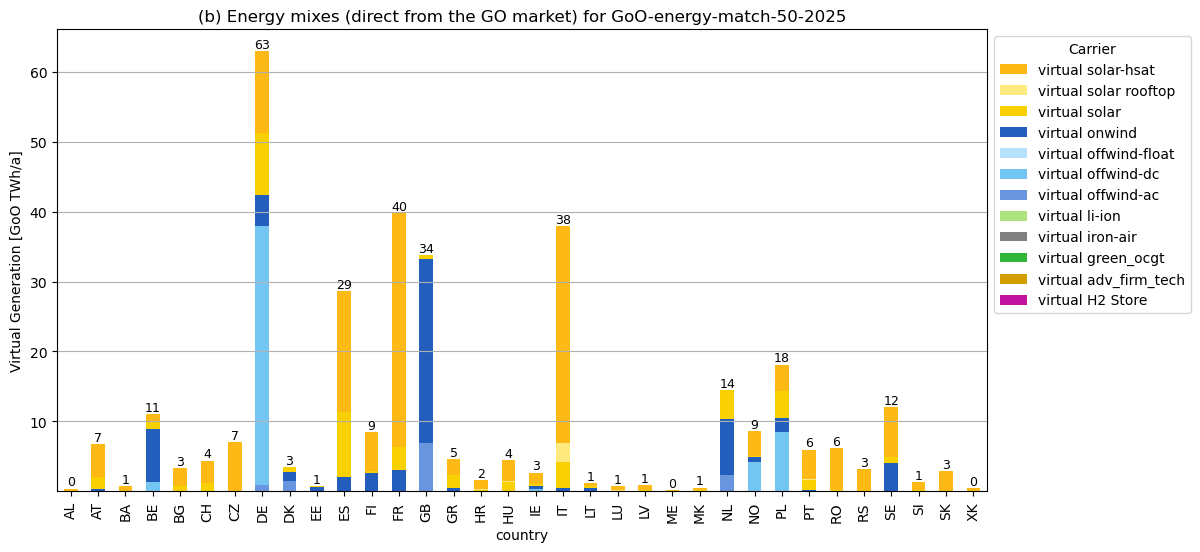

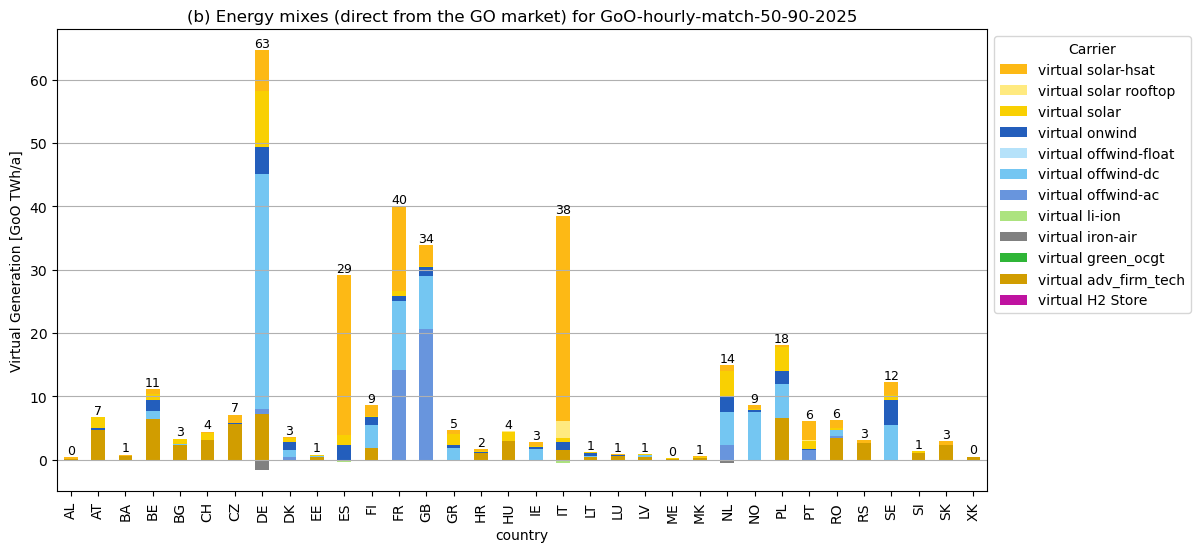

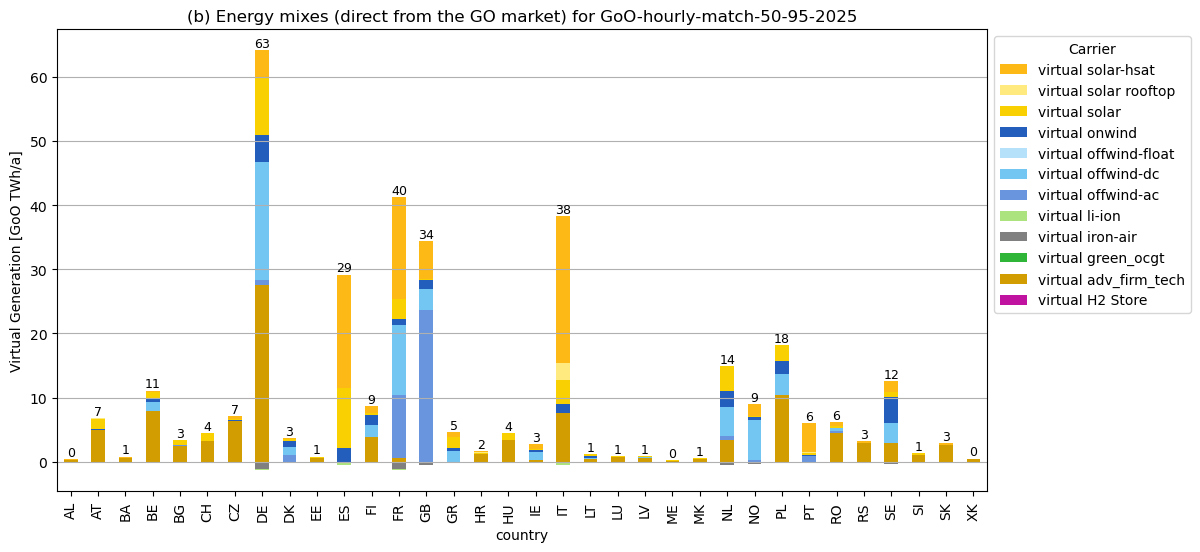

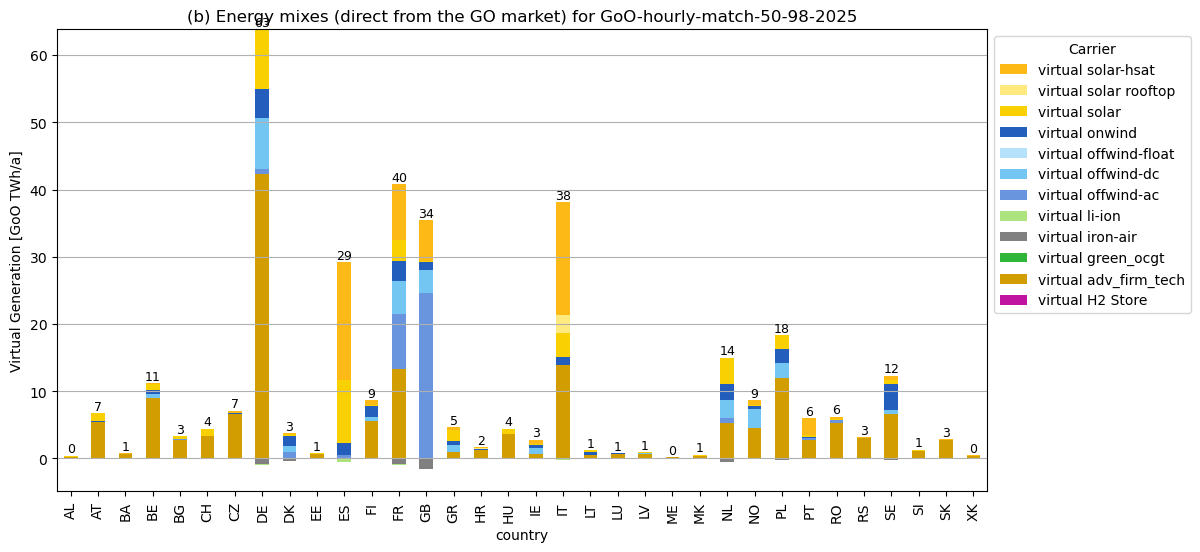

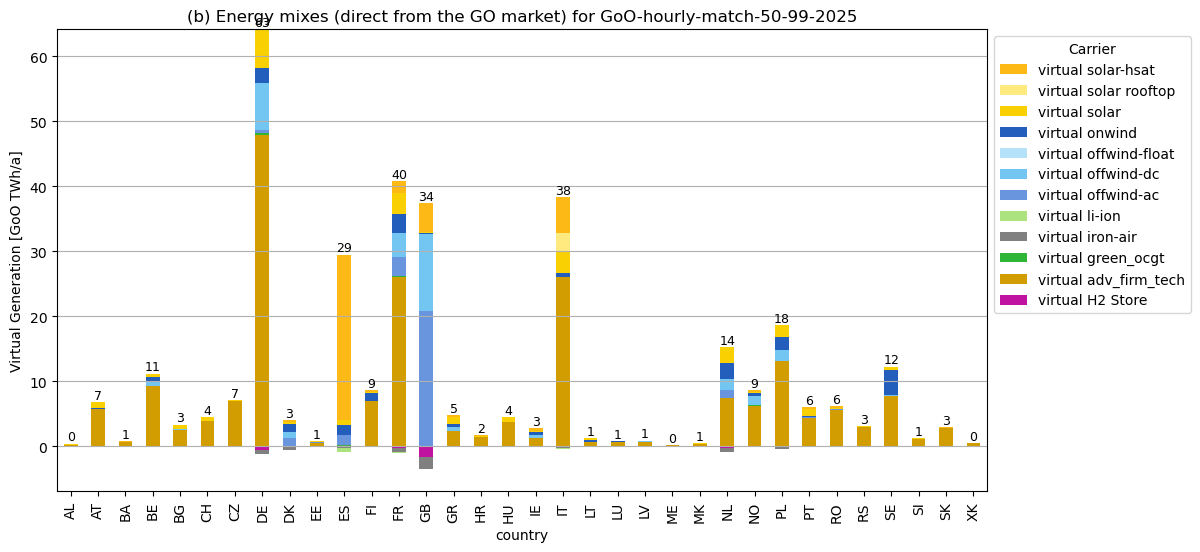

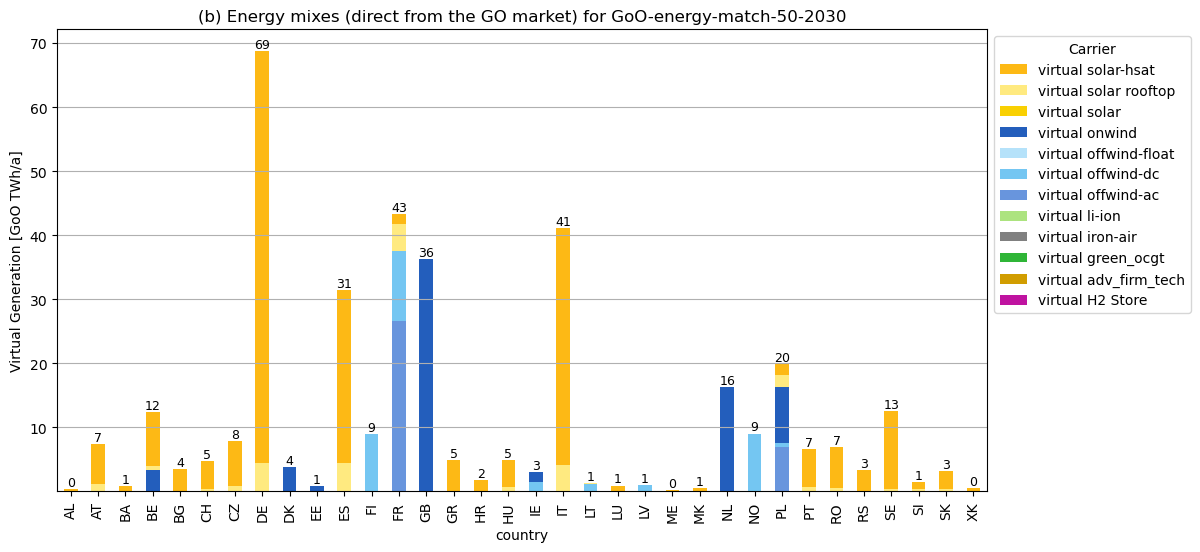

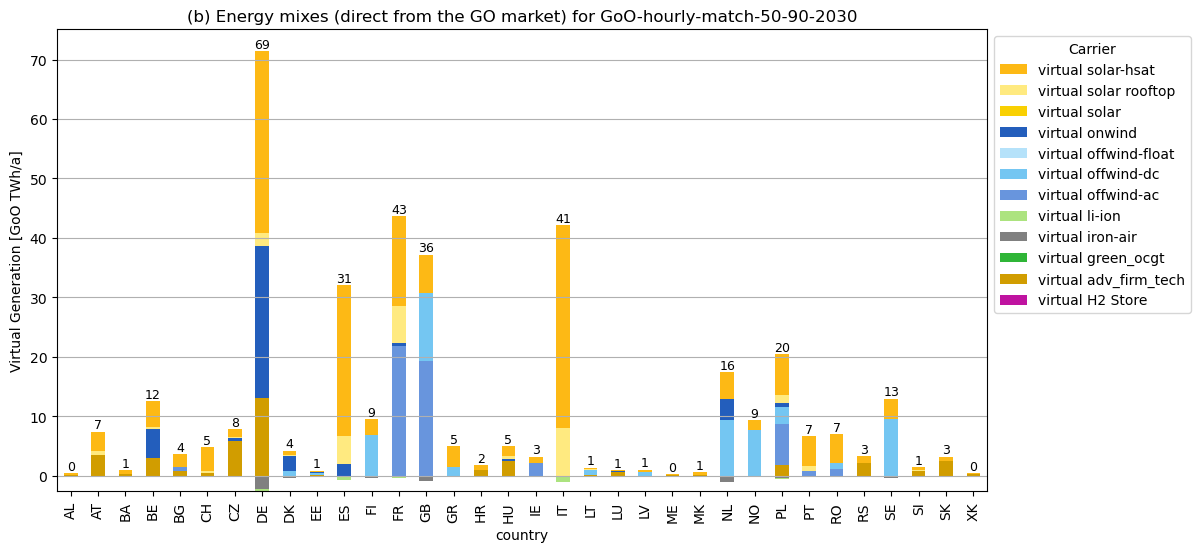

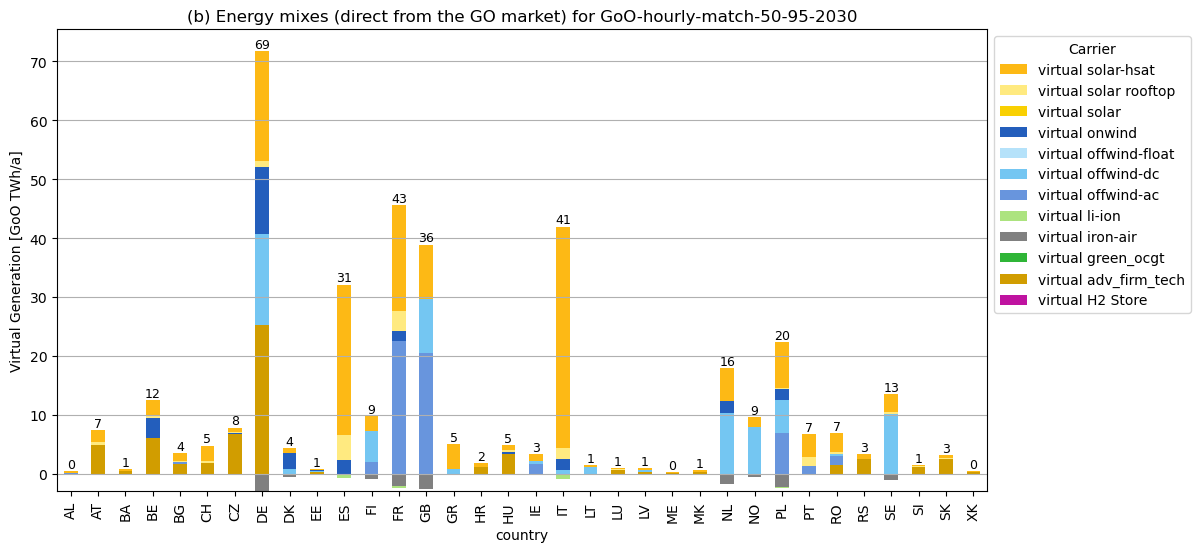

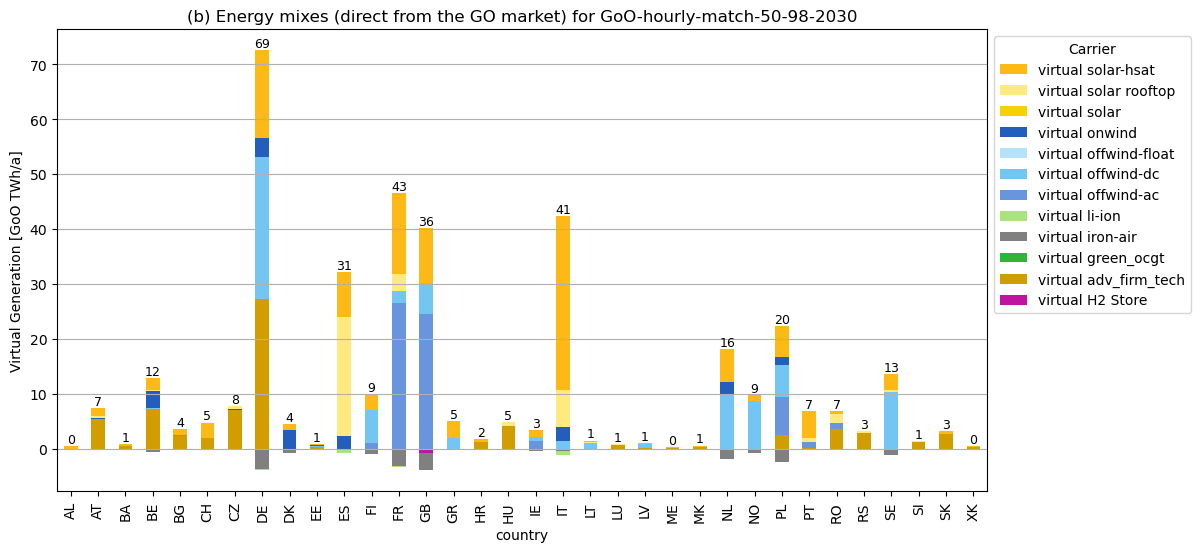

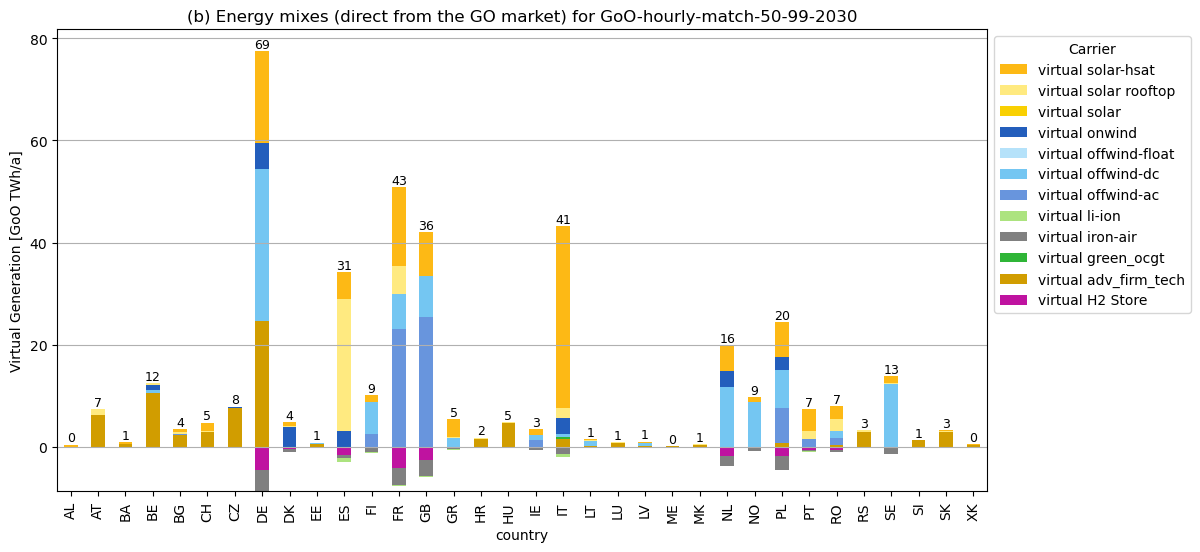

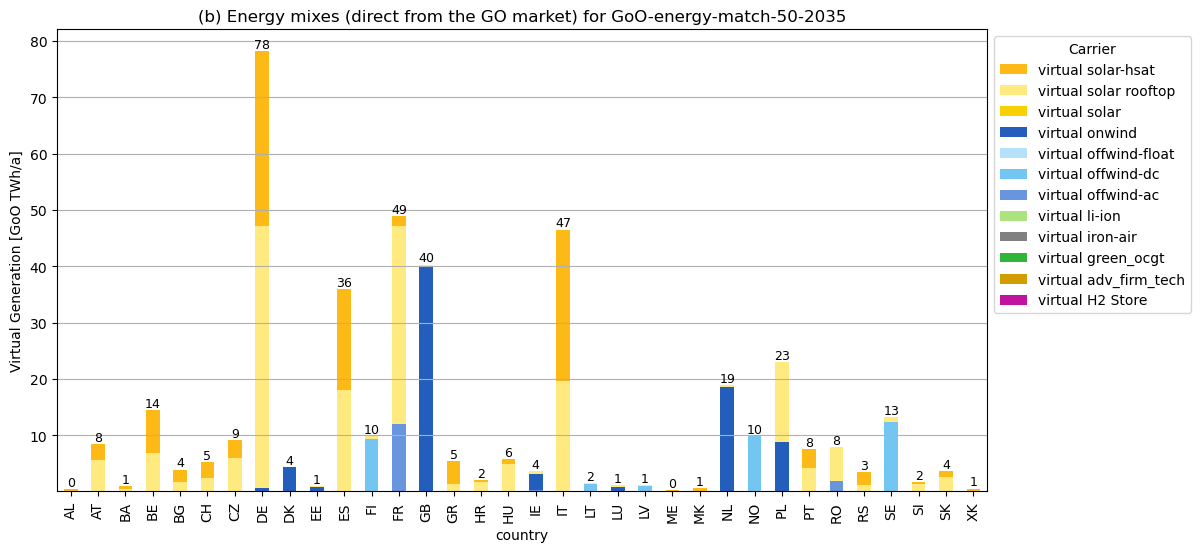

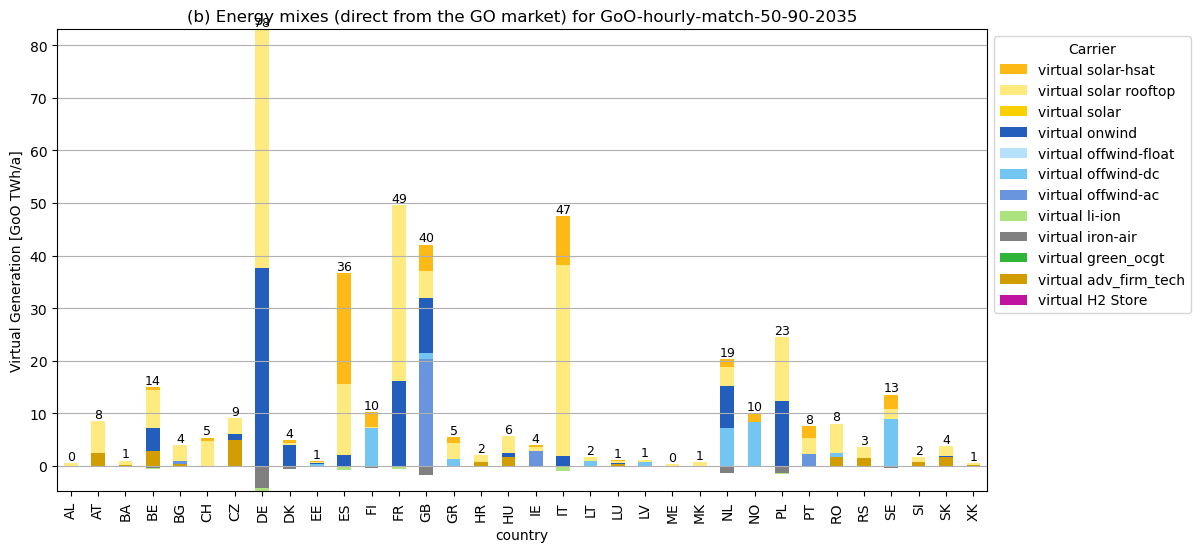

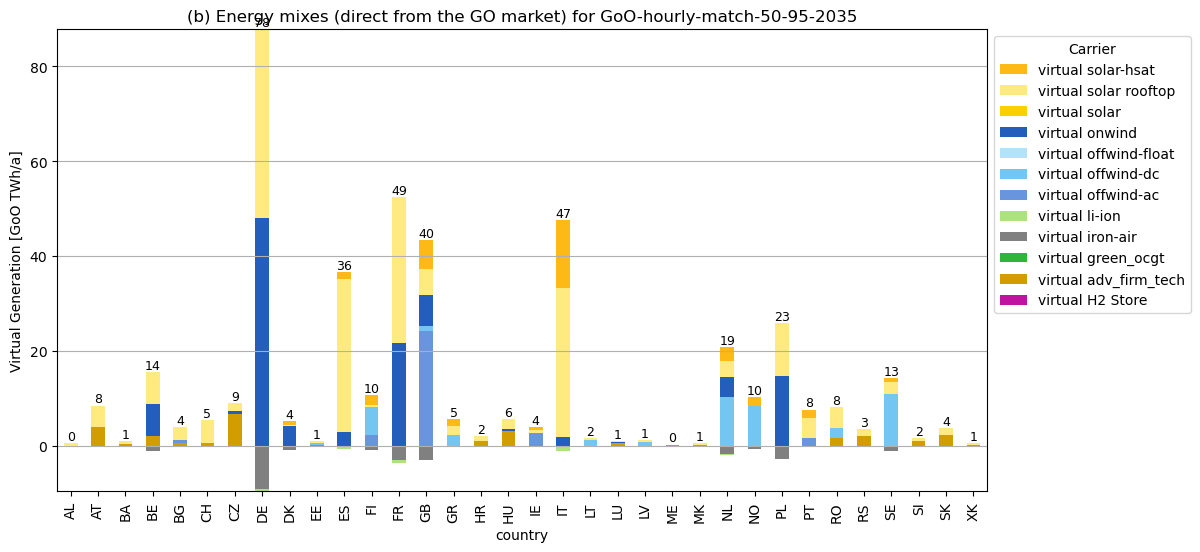

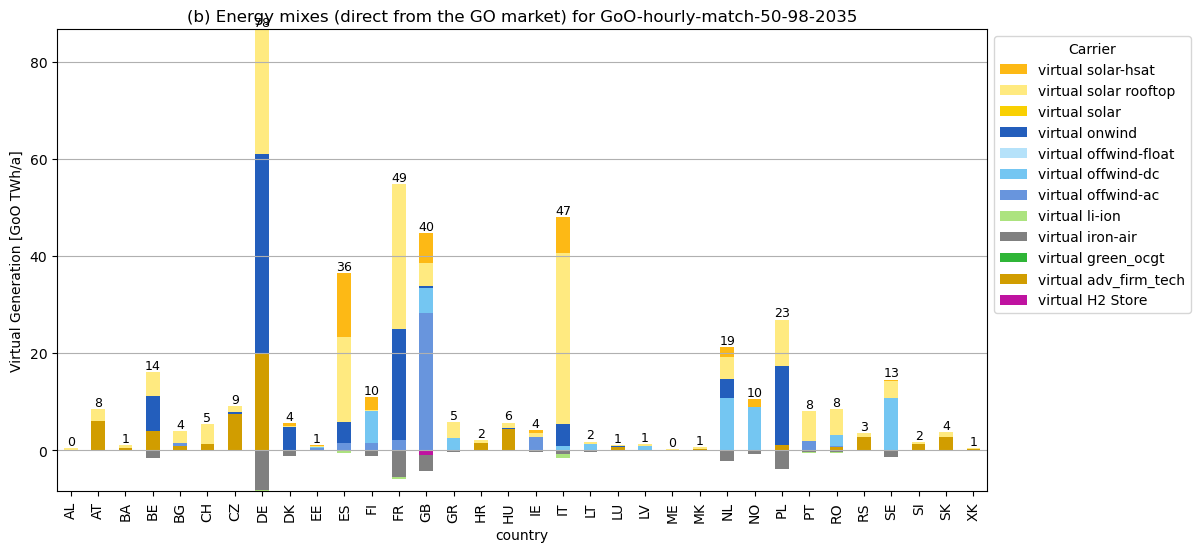

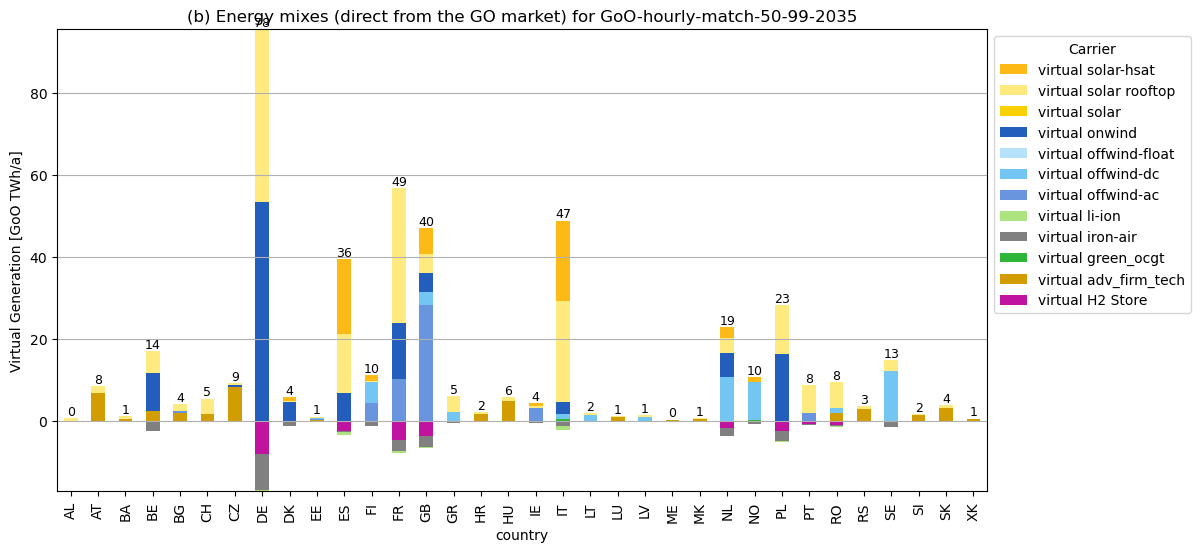

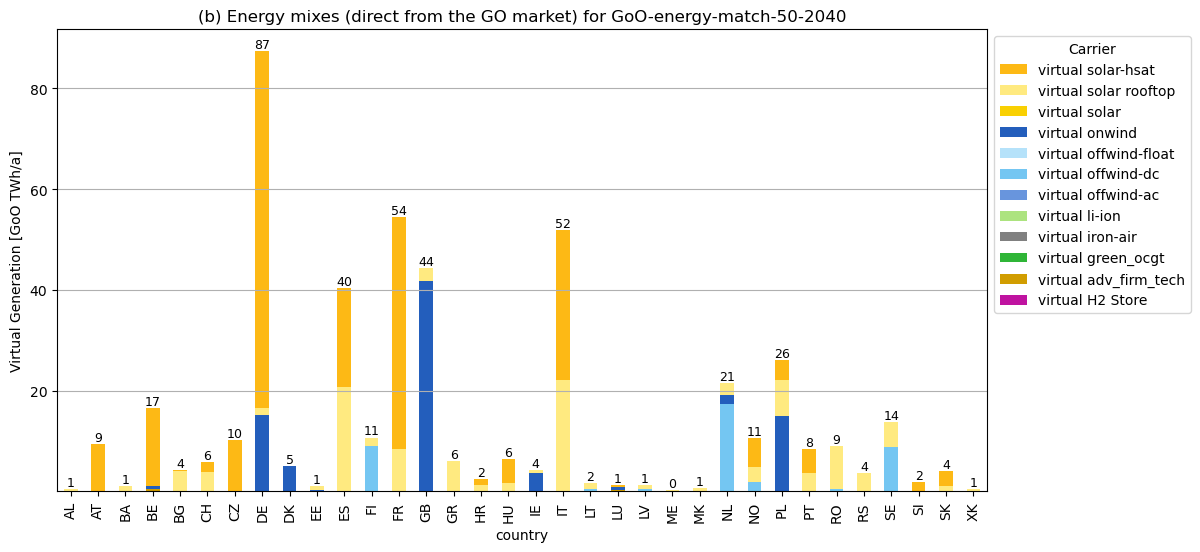

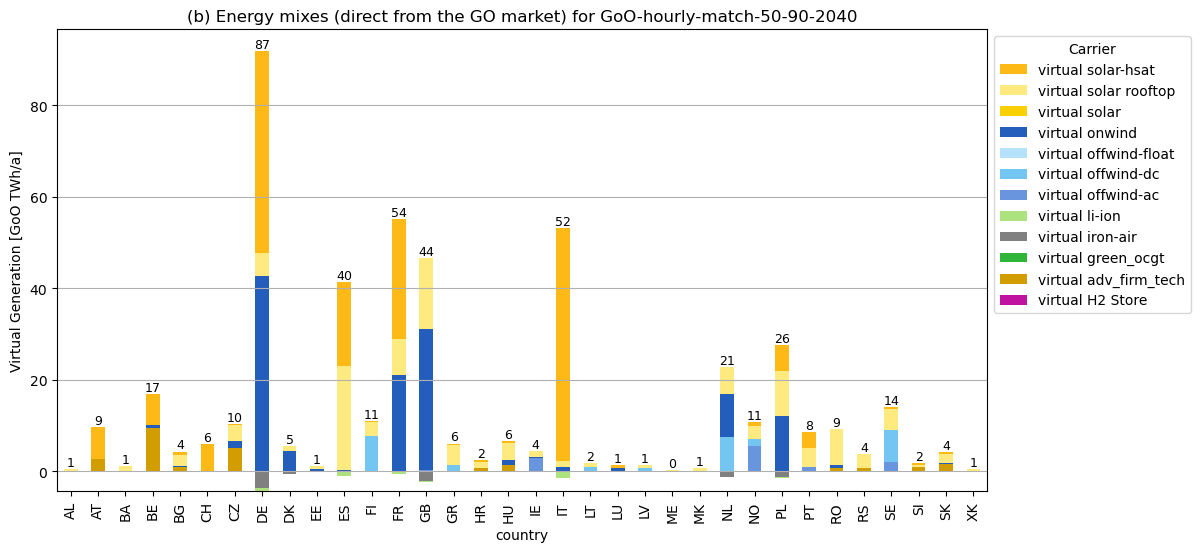

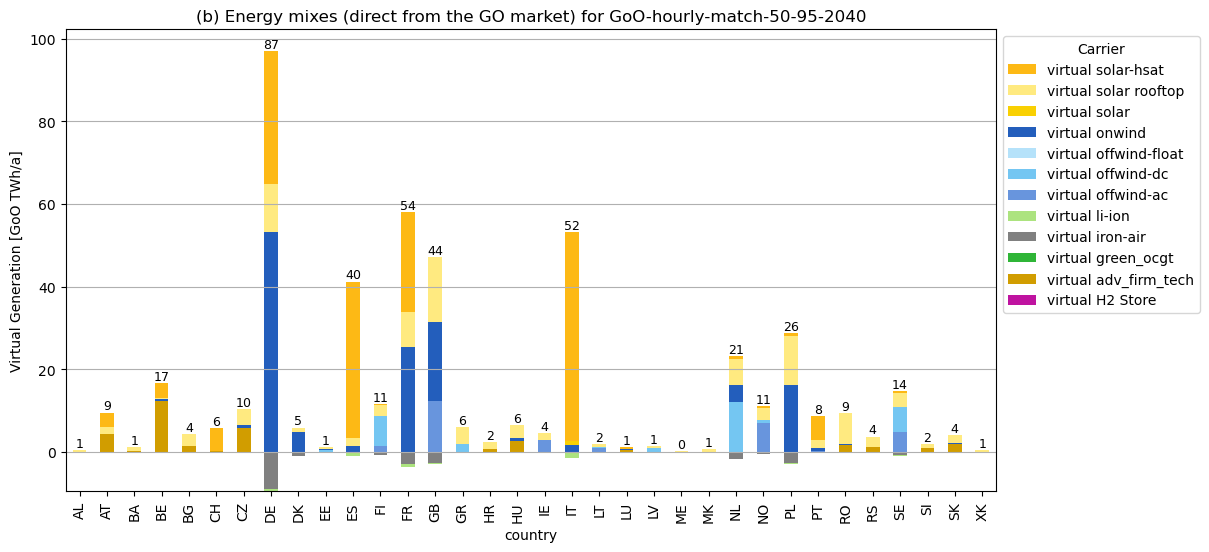

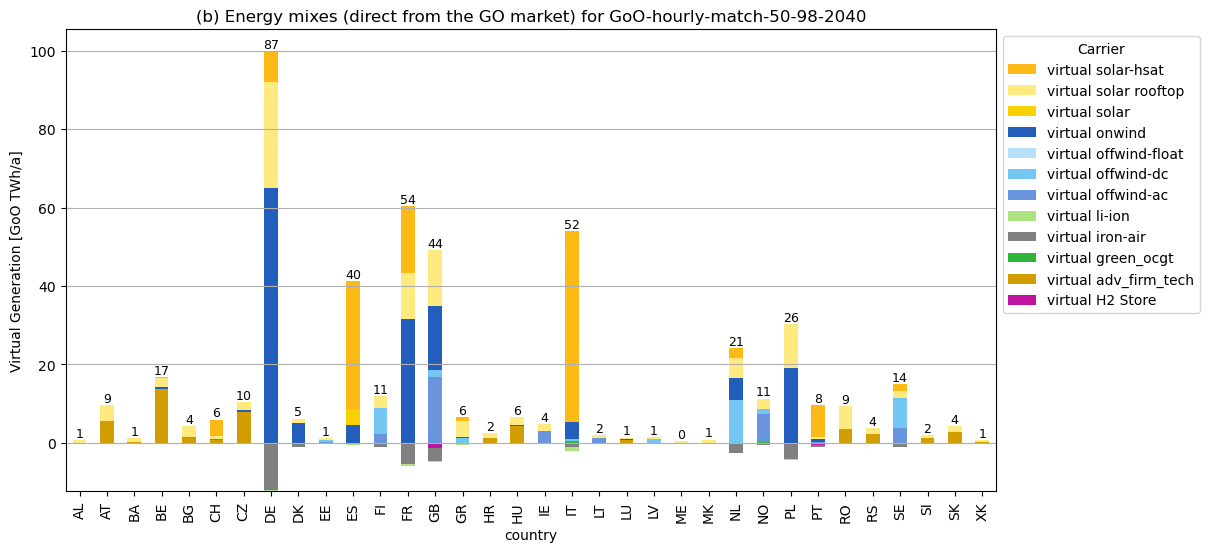

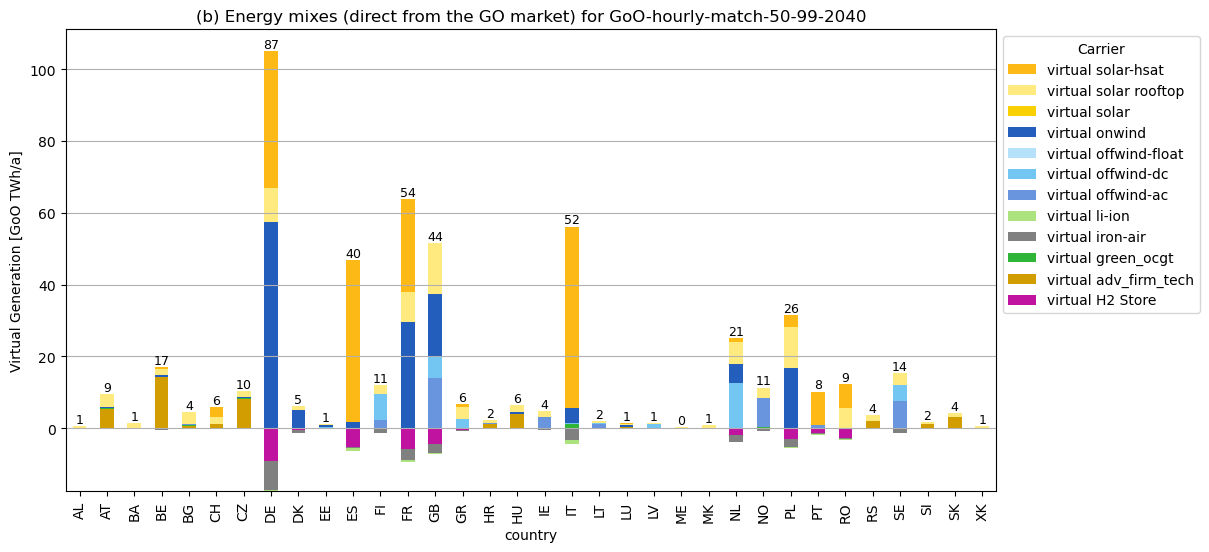

In [98]:
df_GoO = df_networks[df_networks.index.get_level_values("scenario") != "baseline"]
df, _ = get_stats_all(df_GoO["GoO"], "energy_balance", groupby=["country","carrier"])
df = df[df.index.get_level_values("carrier") != "GoO"]

for i in df.columns:
    df_country = df[i]
    df_country = df_country.unstack("country").groupby("carrier").sum()
    df_country = df_country / 1e6

    colors = df_country.index.map(n.carriers.color)
    
    ax = plot_bar(
        df_country, 
        colors, 
        ylabel="Virtual Generation [GoO TWh/a]", 
        title=f"(b) Energy mixes (direct from the GO market) for {i}",
        vert_lines=False
    )

In [322]:
# df, colors = get_stats_all(df_networks["network"], "energy_balance", groupby=["carrier","bus_carrier","location"])
# df["color"] = colors

# df = df[
#     df.index.get_level_values("bus_carrier").isin(["AC","low voltage"]) # TODO: Missing lower voltage technologies
#     & ~df.index.get_level_values("carrier").isin(["electricity","low voltage","electricity distribution grid"])
# ]

# df = df.groupby(["location","carrier"]).apply(sum_except_color)
# df = df.rename(index=grouping_storage).groupby(["location","carrier"]).apply(sum_except_color)

# df.index.names = ['bus','carrier']
# colors = df["color"]
# df = df.drop("color", axis=1)
# df = df / 1e6

# plot_map(df, df_networks["network"], colors, unit="Energy Balance [TWh/a]", title="(a) Total Energy Mixes", bus_size_factor=4e1)

### (b) Energy mixes (direct from the GO market)

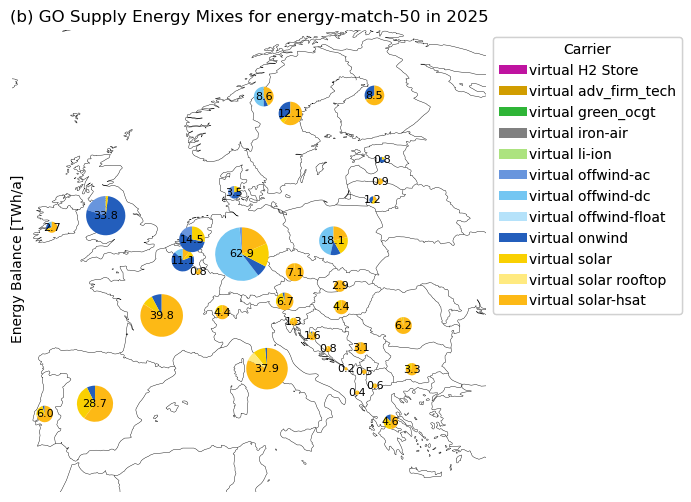

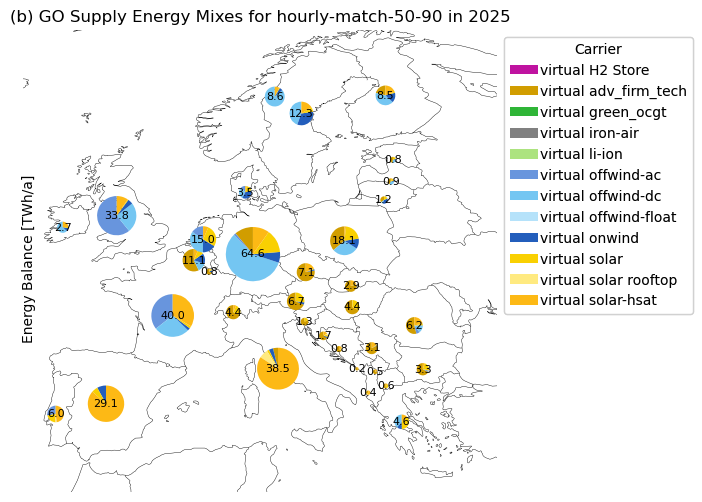

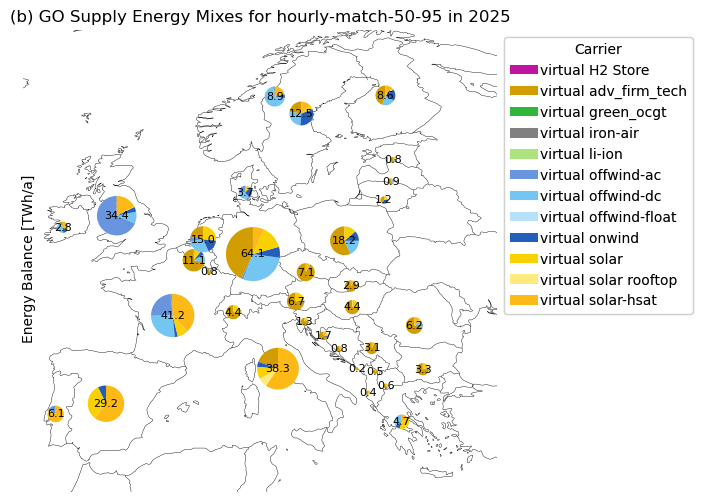

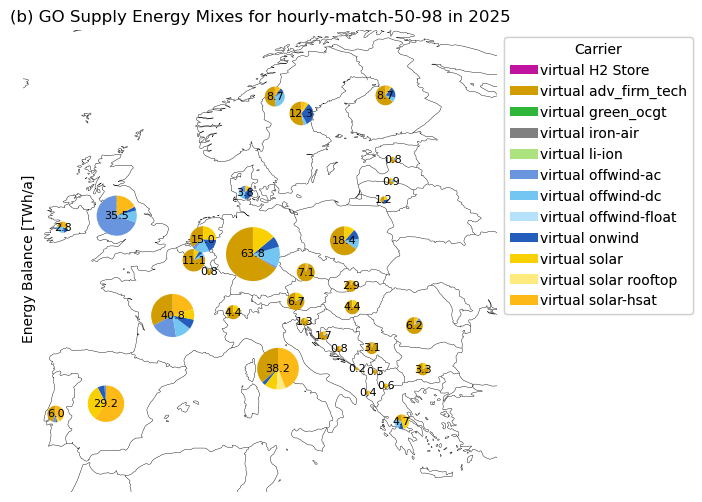

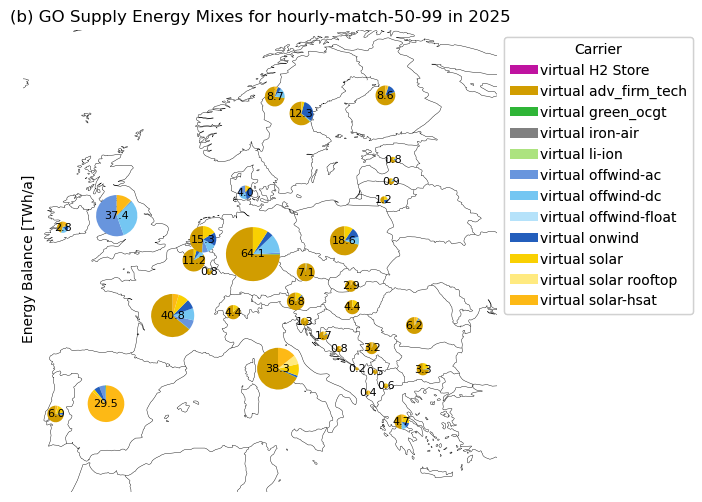

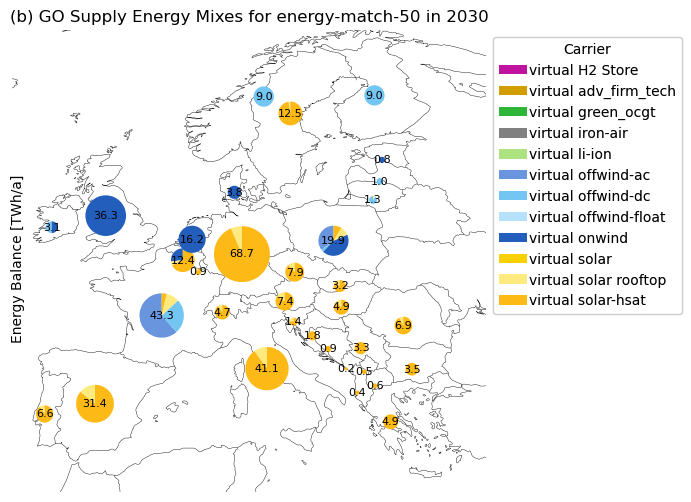

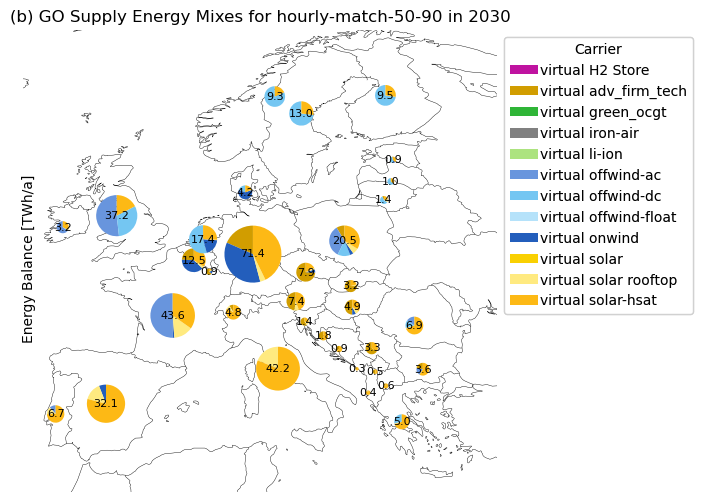

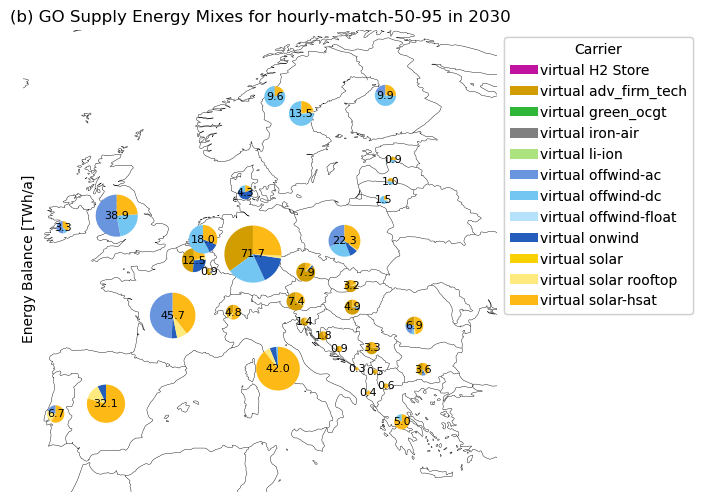

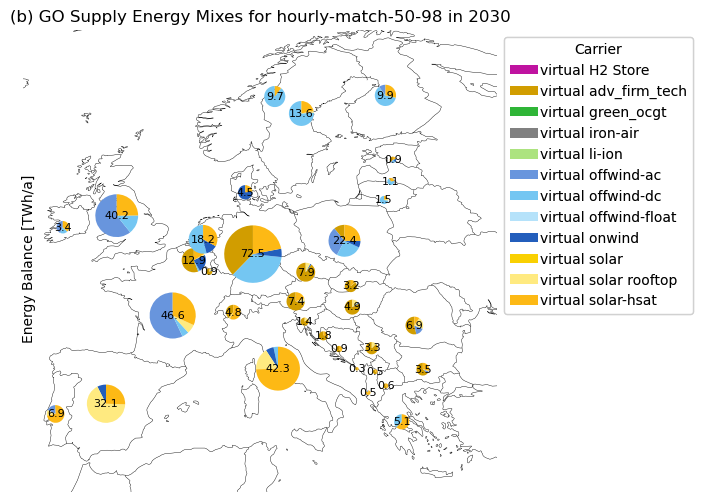

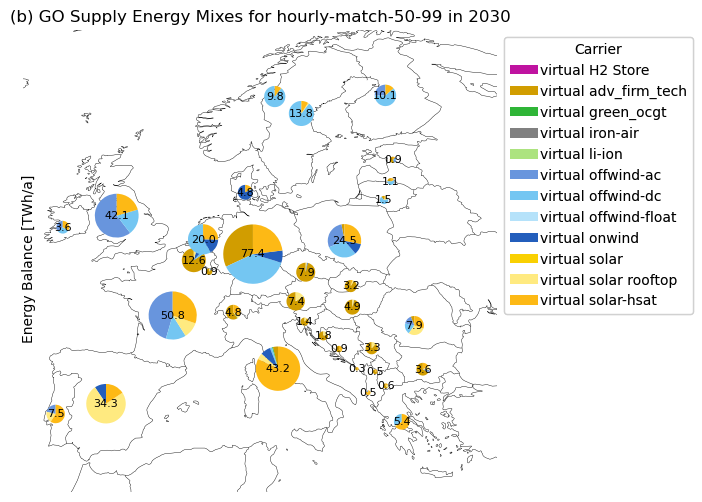

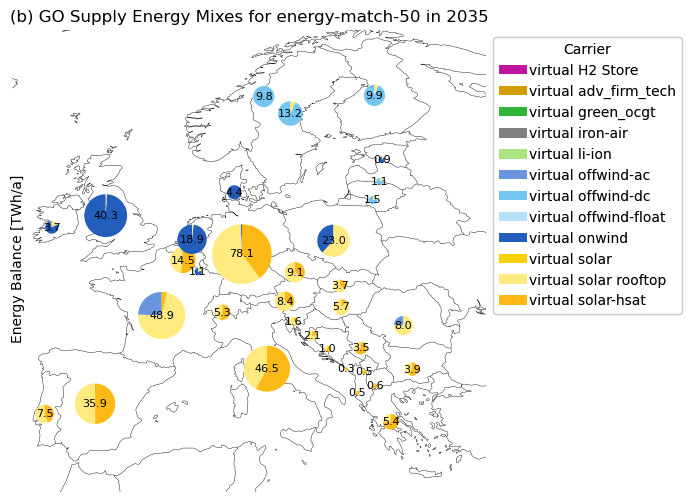

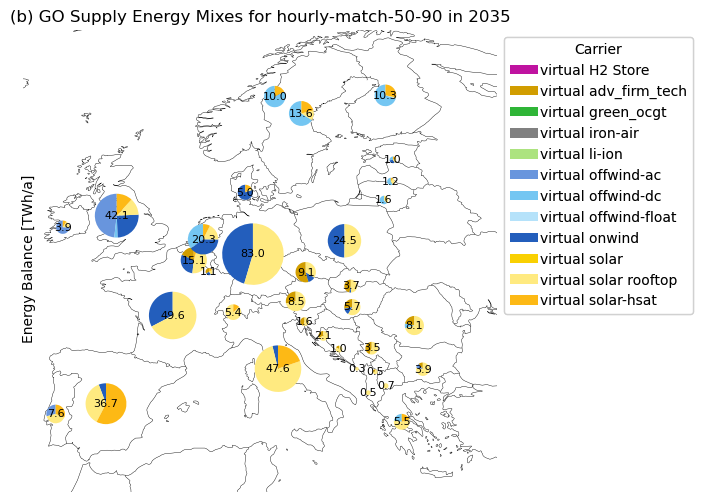

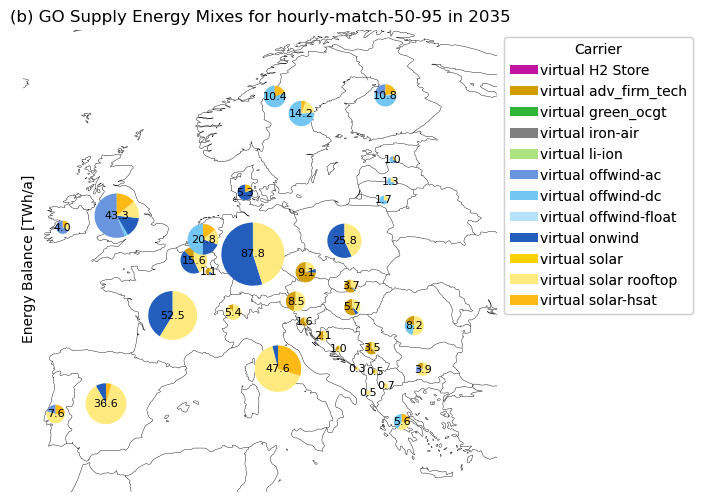

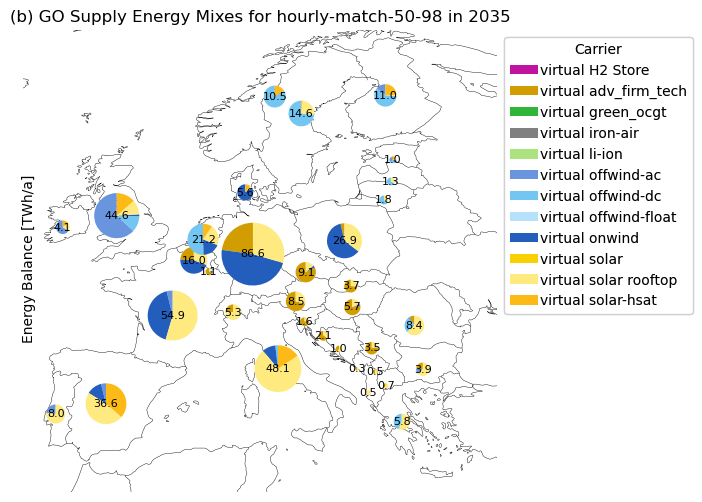

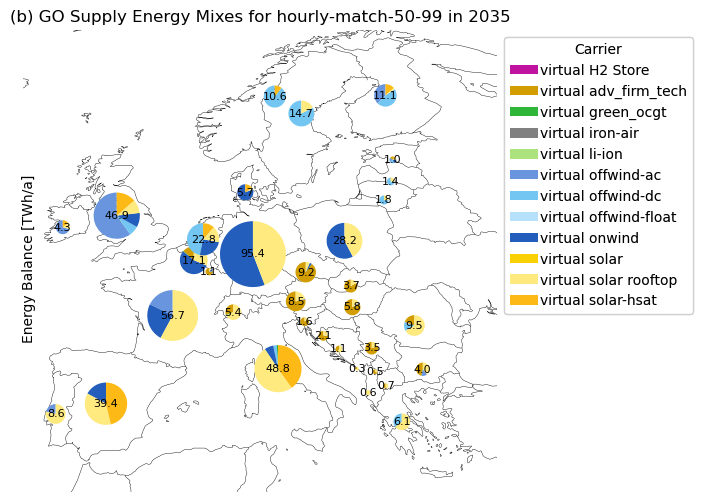

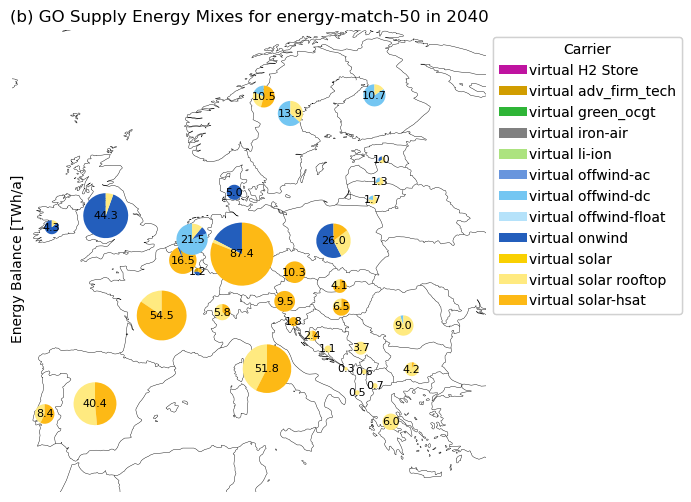

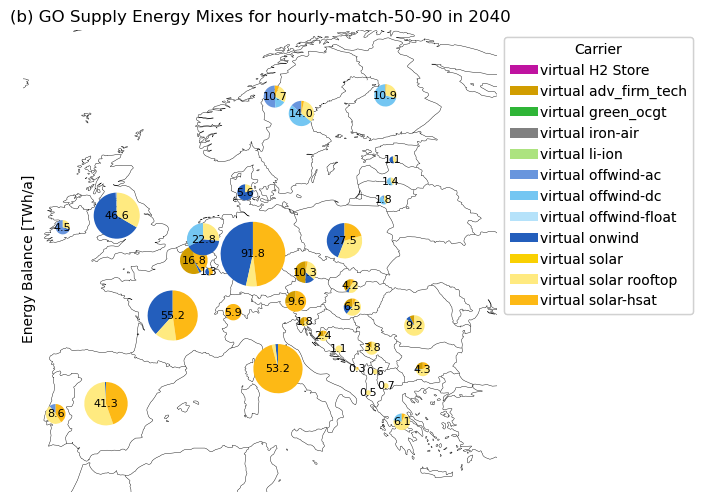

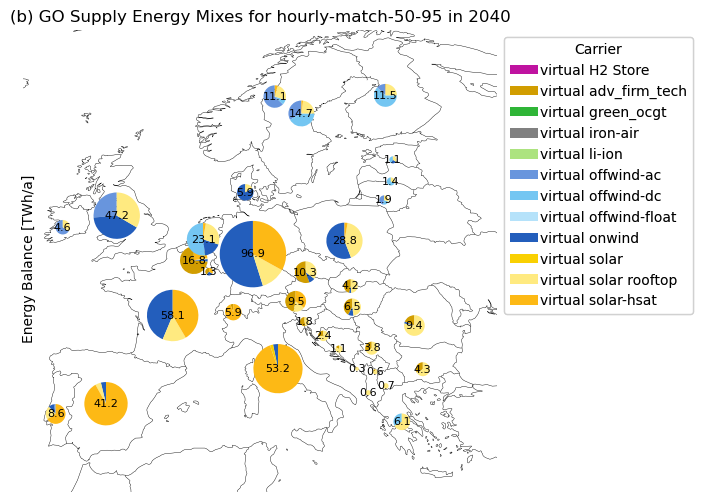

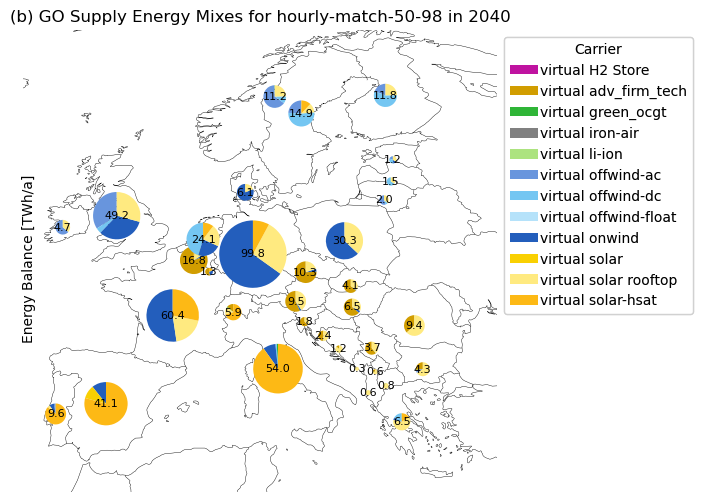

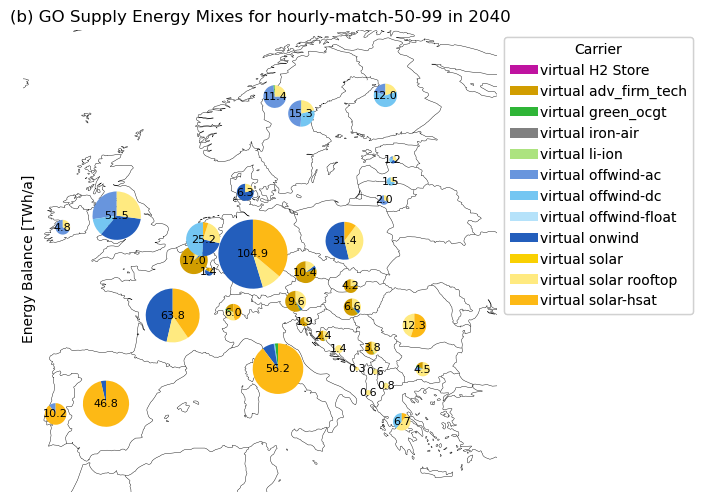

In [325]:
df_GoO = df_networks[df_networks.index.get_level_values("scenario") != "baseline"]
df, colors = get_stats_all(df_GoO["GoO"], "energy_balance", groupby=["bus","carrier"])
df["color"] = colors
df = df[df.index.get_level_values("carrier") != "GoO"].groupby(["bus","carrier"]).apply(sum_except_color)

colors = df["color"]
df = df.drop("color", axis=1)
df = df / 1e6

plot_map(df, df_GoO["GoO"], colors, unit="Energy Balance [TWh/a]", title="(b) GO Supply Energy Mixes")

### (i) Weighted Average Marginal Price of GOs

/home/virio-andreyana/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/statistics/expressions.py:2587: RuntimeWarning:

invalid value encountered in scalar divide

/home/virio-andreyana/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/statistics/expressions.py:2587: RuntimeWarning:

invalid value encountered in scalar divide

/home/virio-andreyana/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/statistics/expressions.py:2587: RuntimeWarning:

invalid value encountered in scalar divide

/home/virio-andreyana/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/statistics/expressions.py:2587: RuntimeWarning:

invalid value encountered in scalar divide

/home/virio-andreyana/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/statistics/expressions.py:2587: RuntimeWarning:

invalid value encountered in scalar divide

/home/virio-andreyana/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/statistics/expressions.py:2587: RuntimeWarn

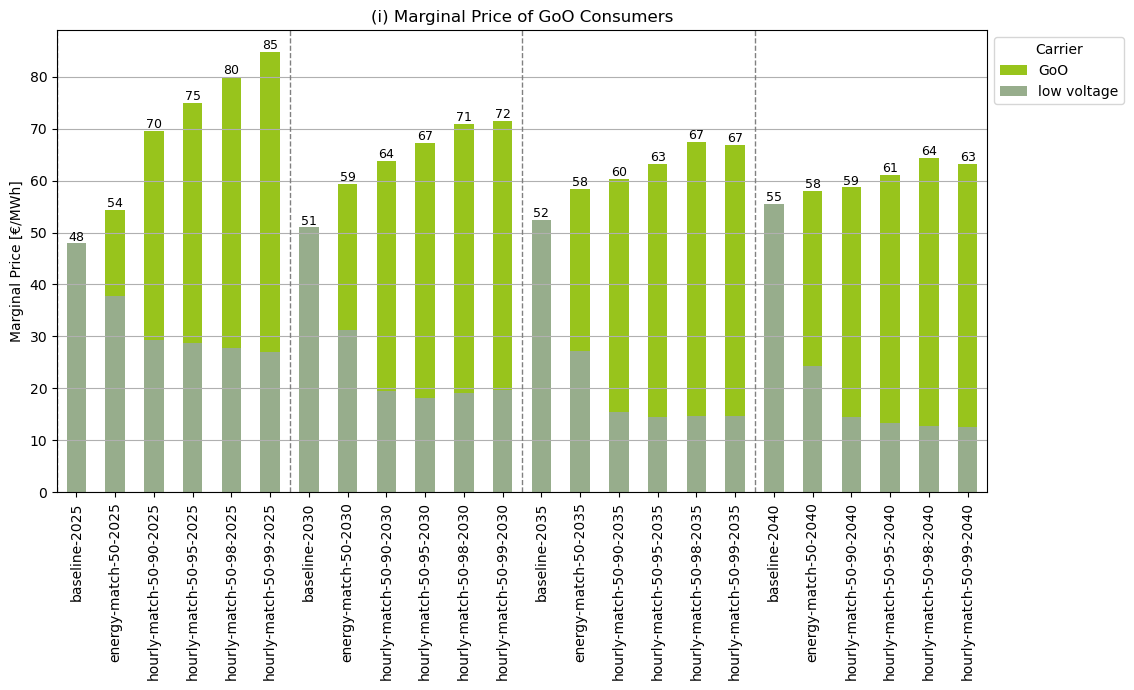

In [6]:
df, colors = get_stats_all(df_networks["network"],"prices", groupby="bus_carrier")

df["color"] = colors
df = df.loc[["low voltage","GoO"]]

colors = df["color"]
df = df.drop("color", axis=1)

ax = plot_bar(df, colors, ylabel="Marginal Price [€/MWh]", title="(i) Marginal Price of GoO Consumers")

/tmp/ipykernel_1886735/4172073146.py:214: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



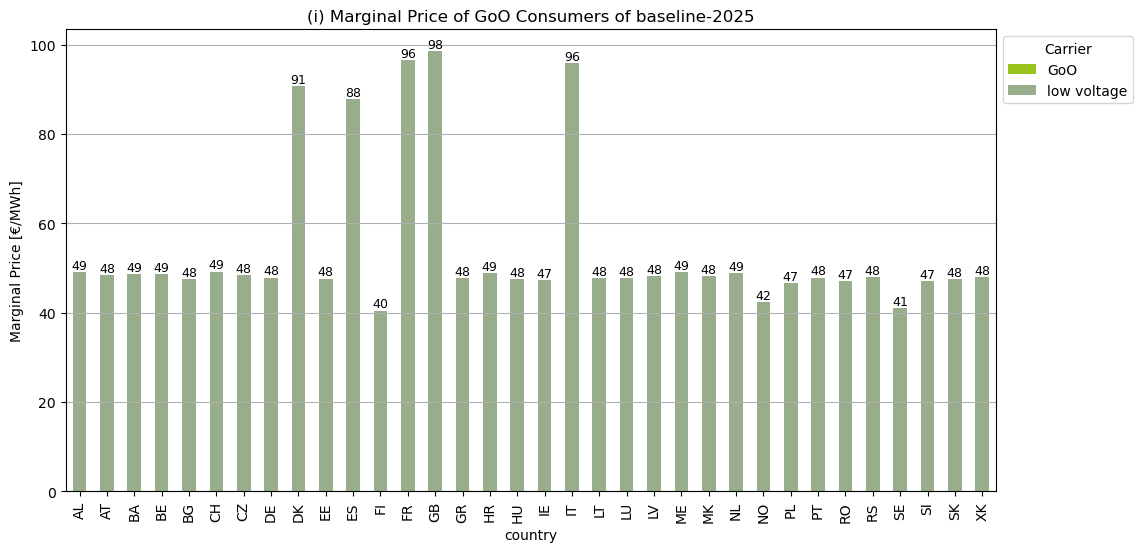

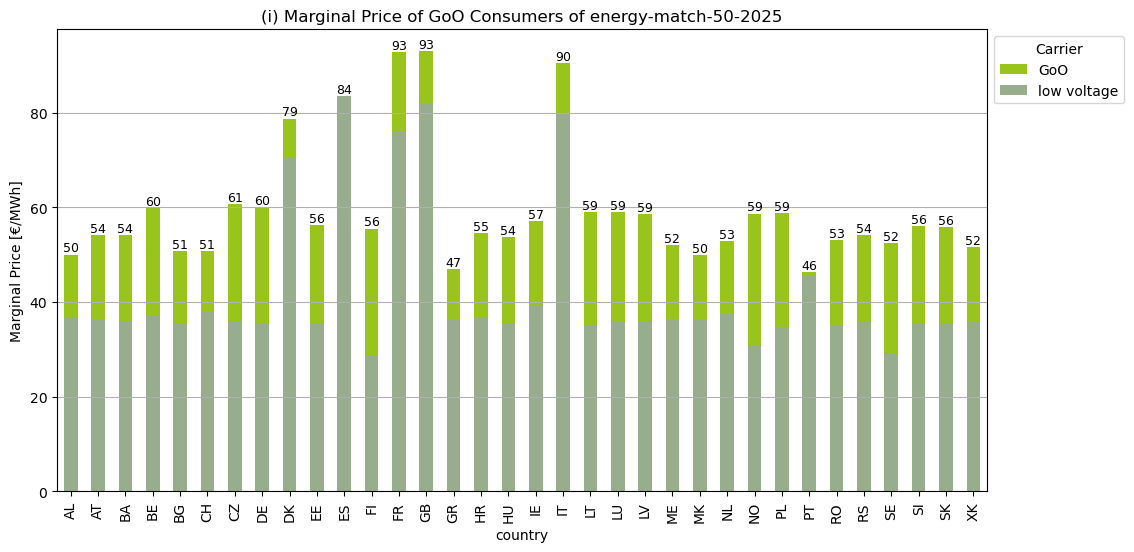

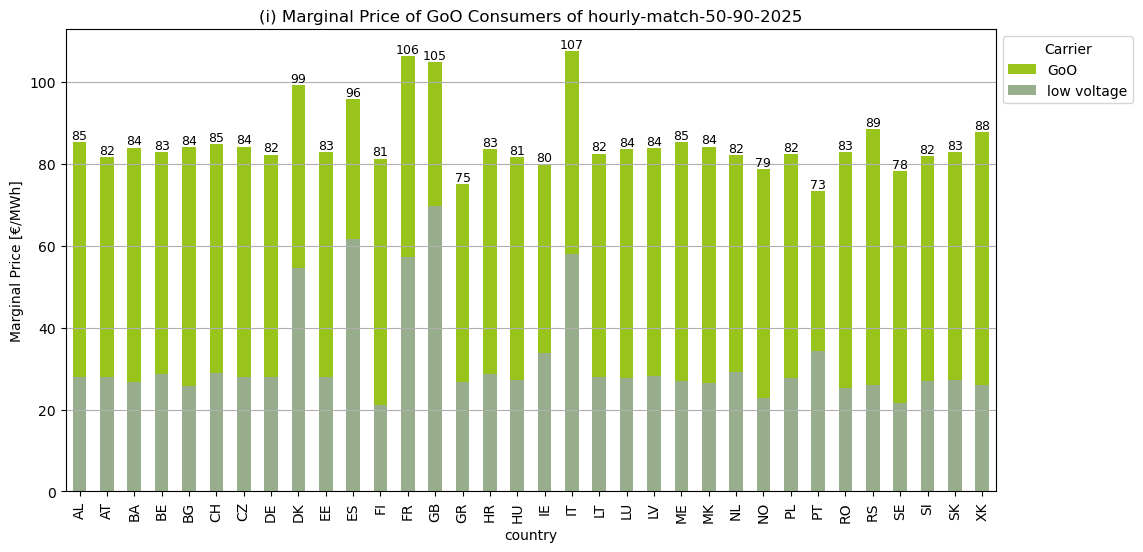

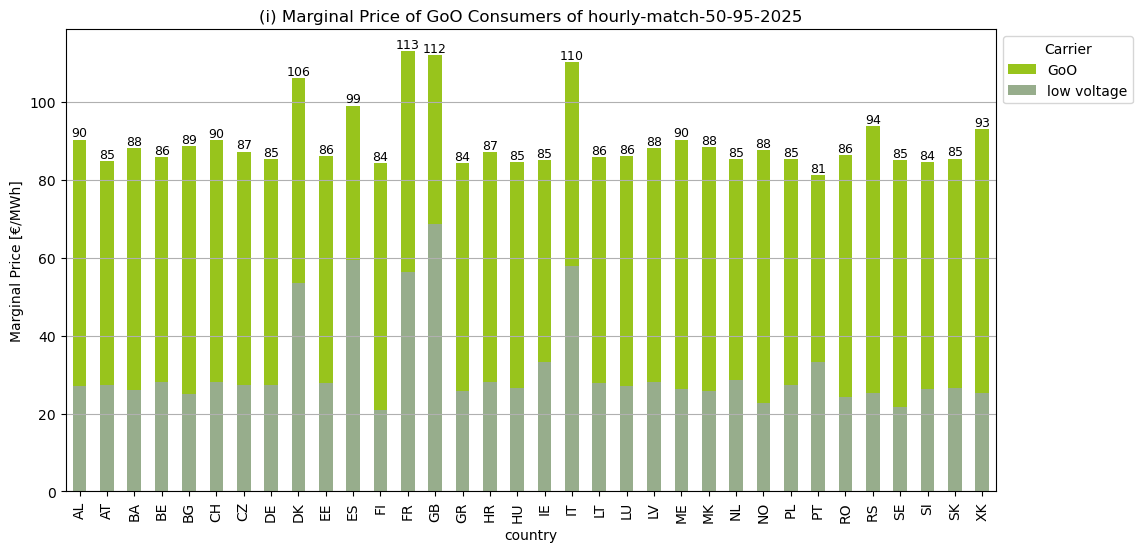

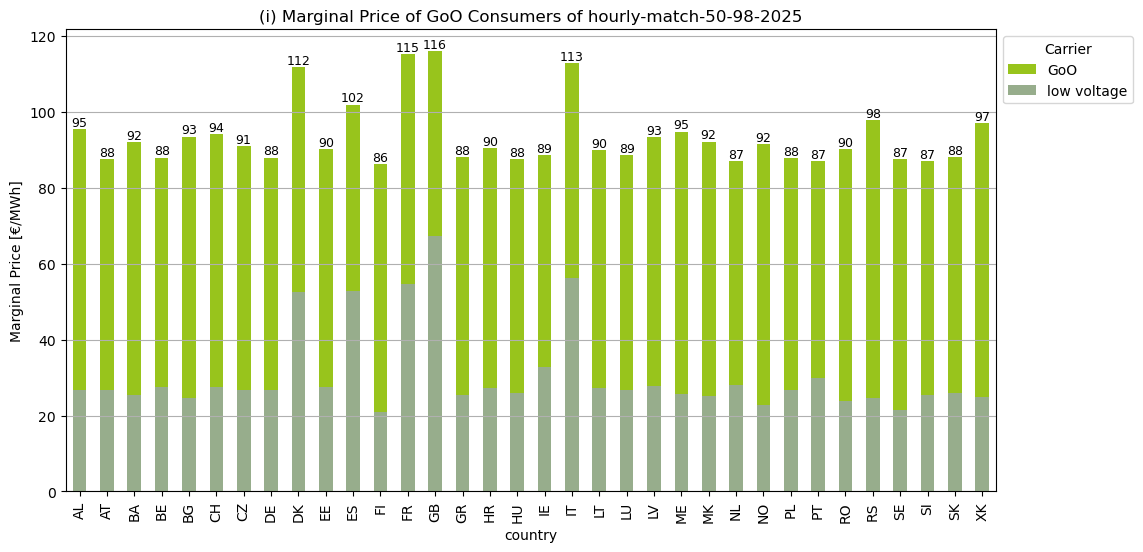

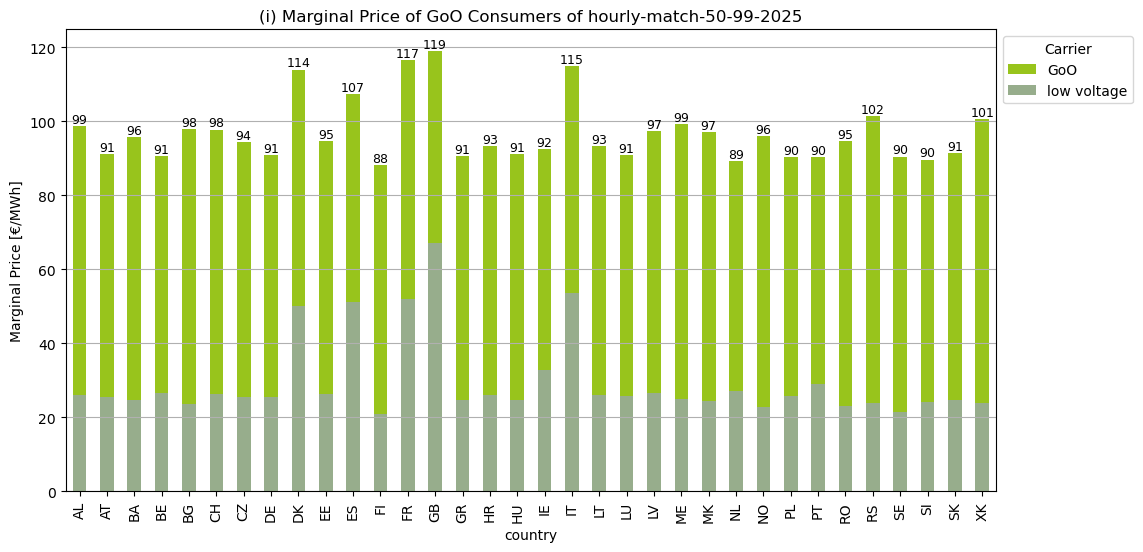

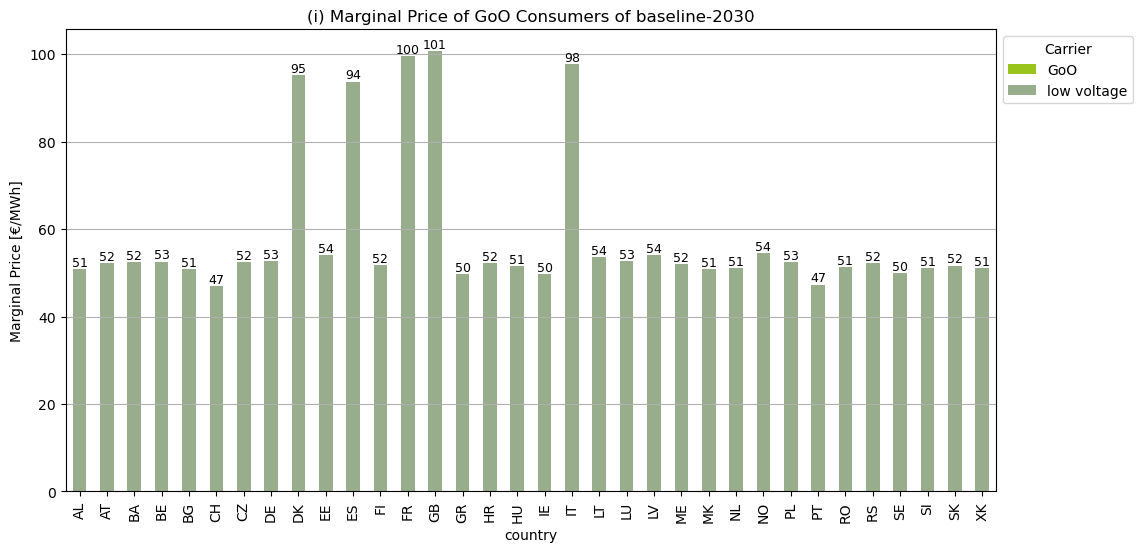

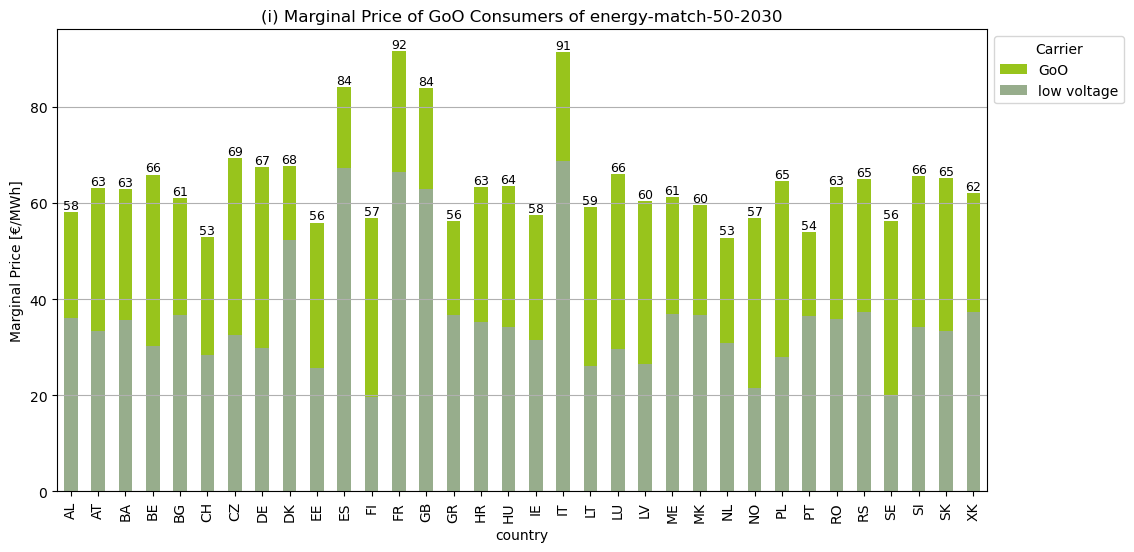

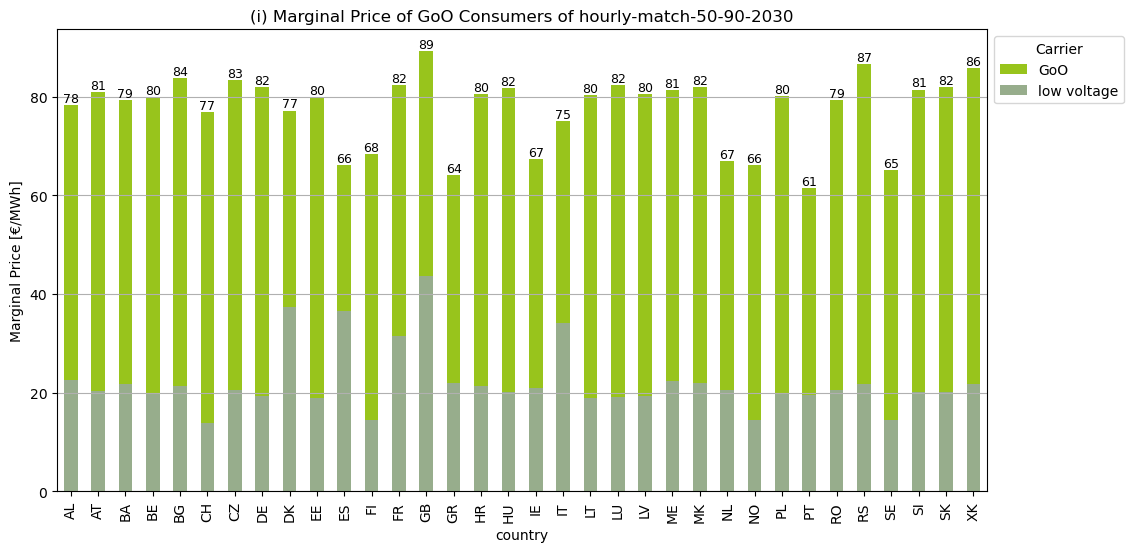

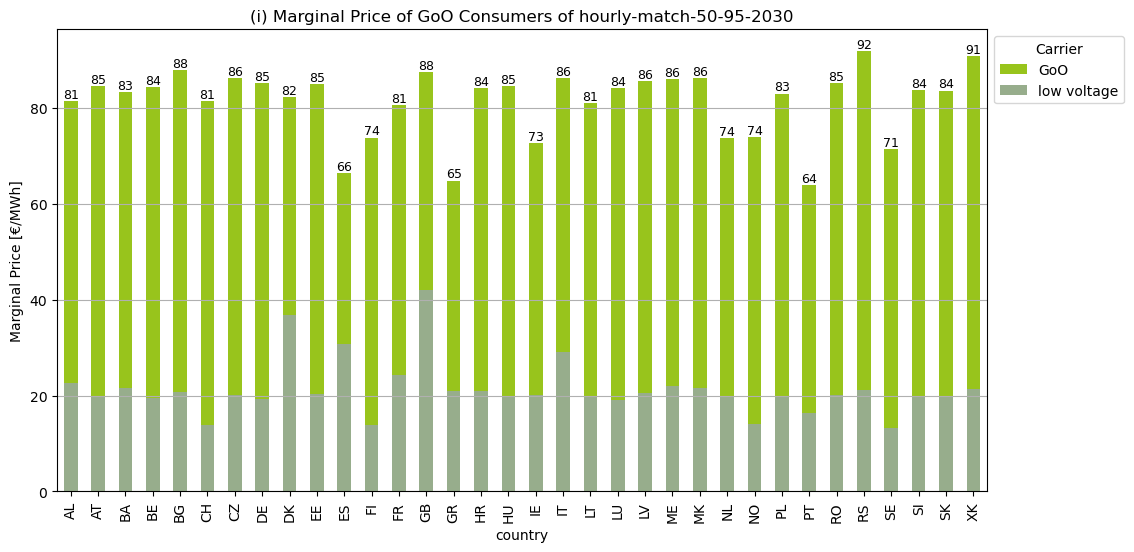

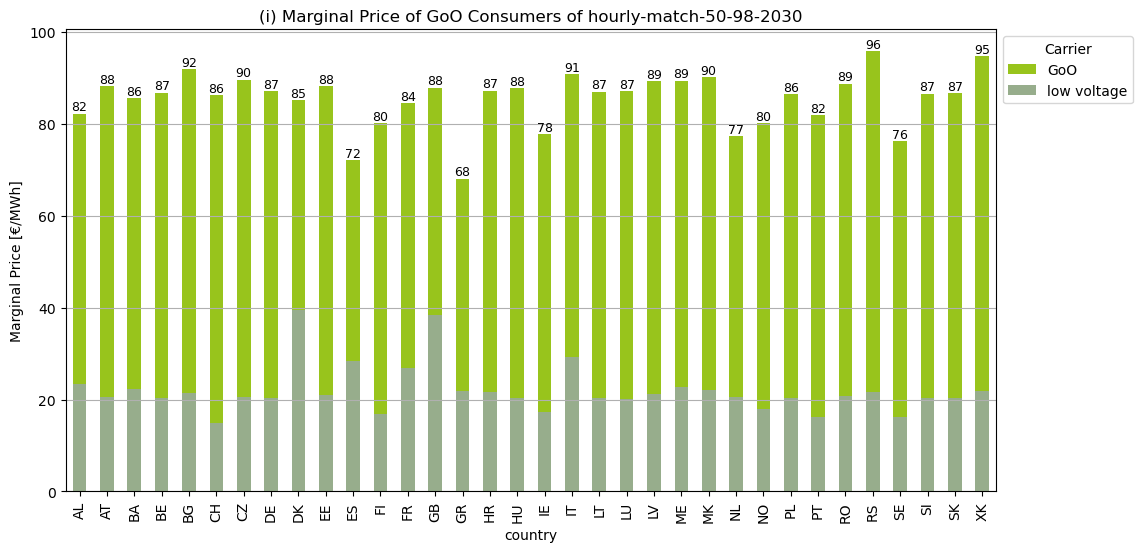

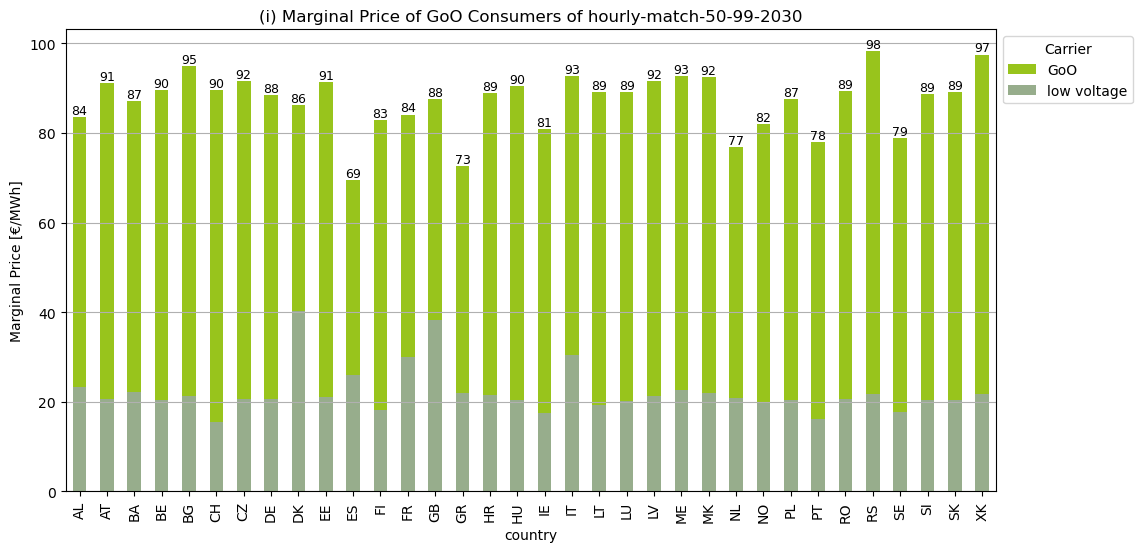

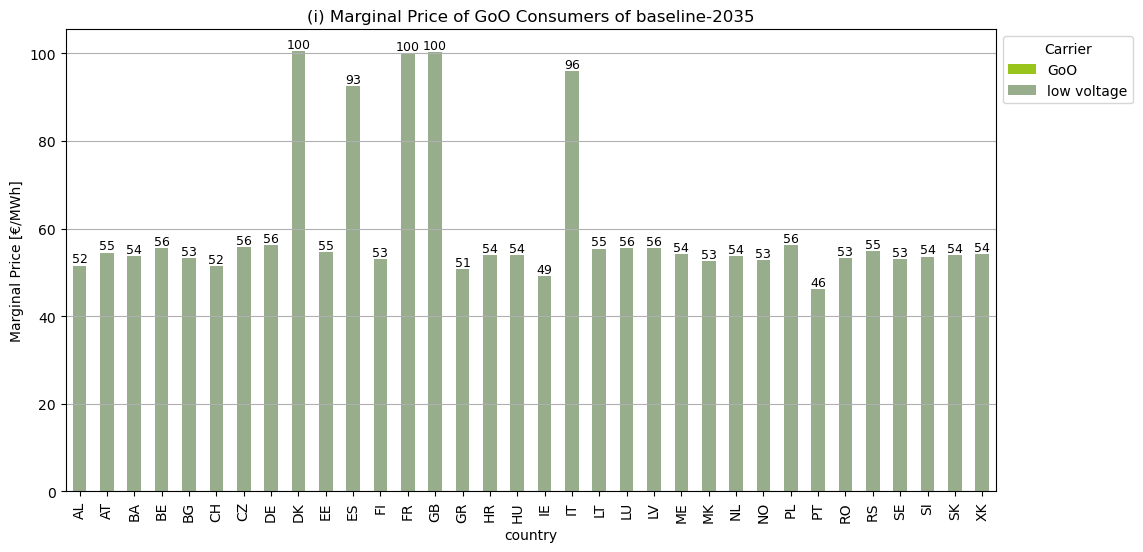

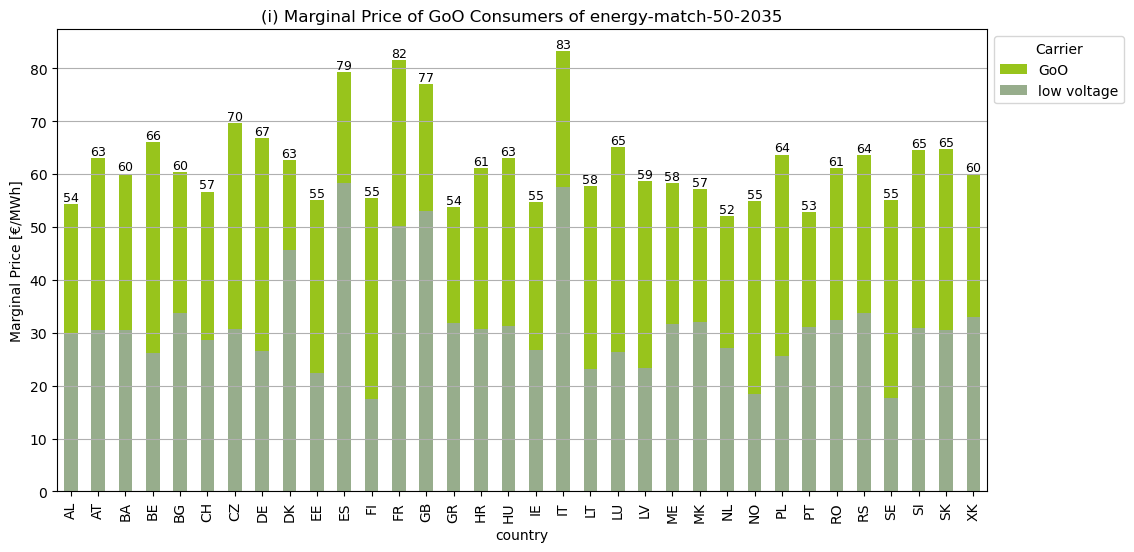

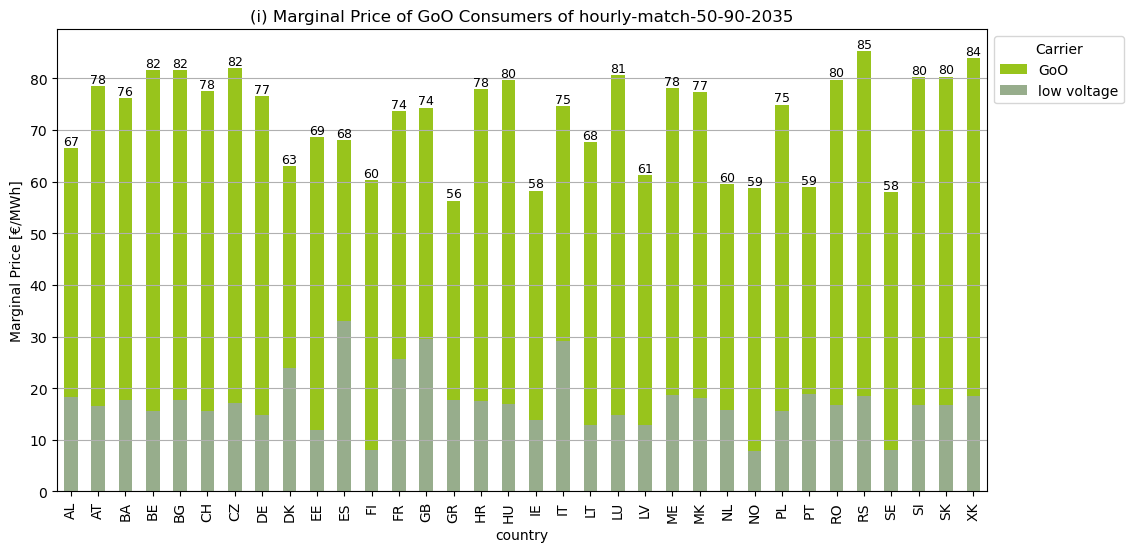

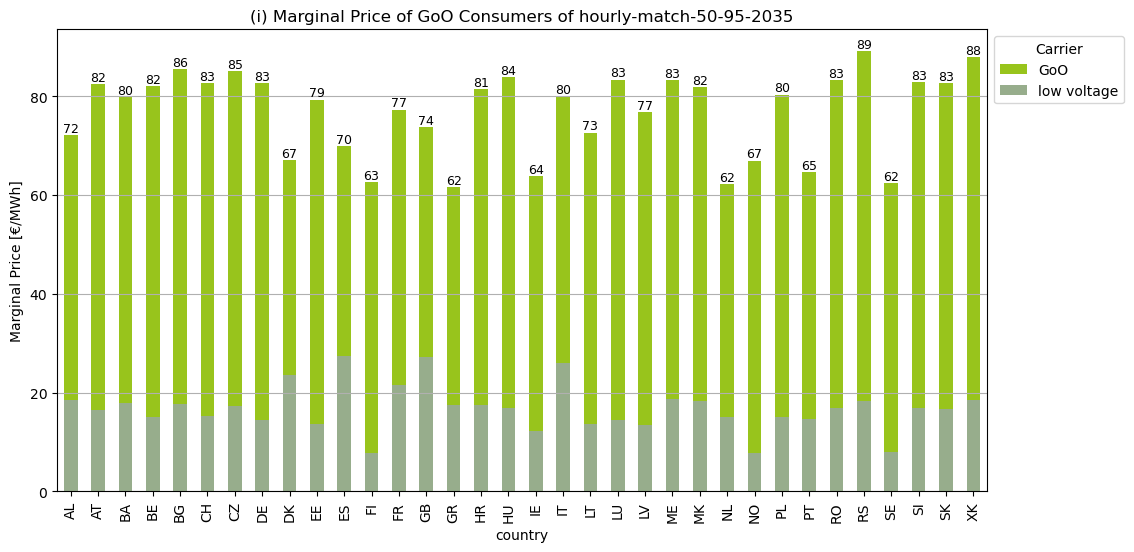

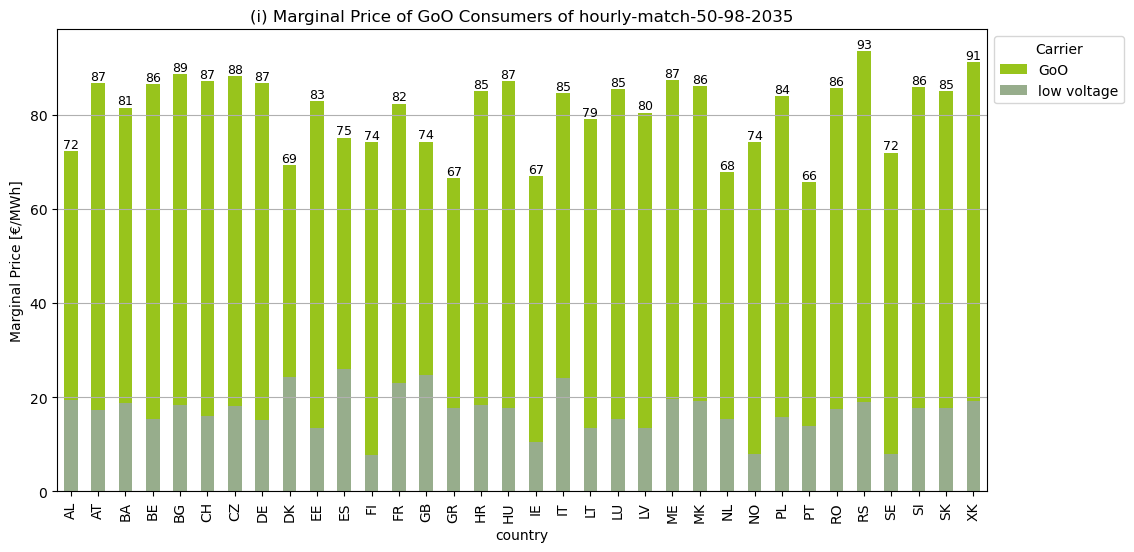

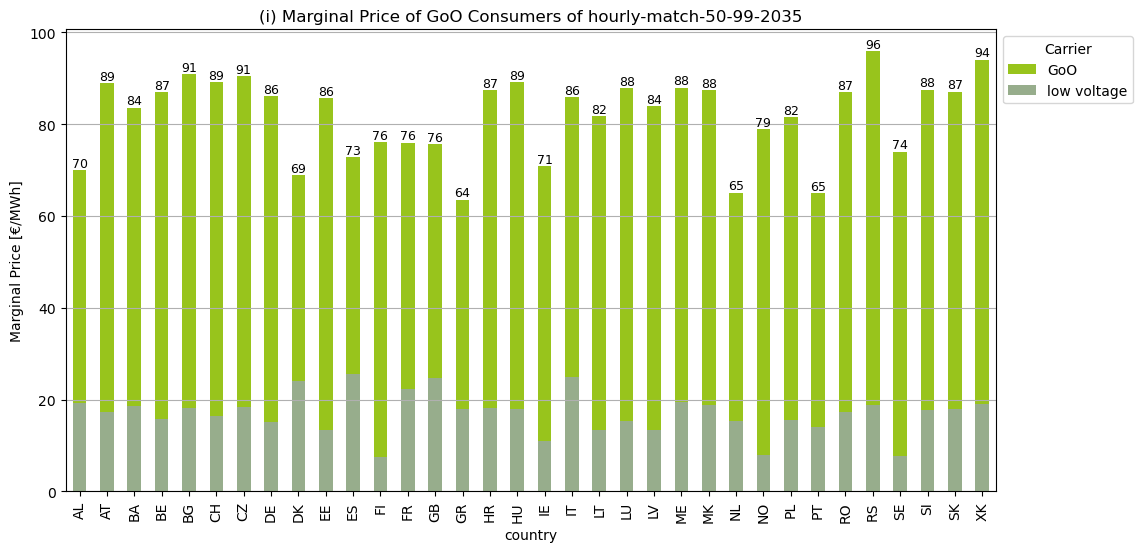

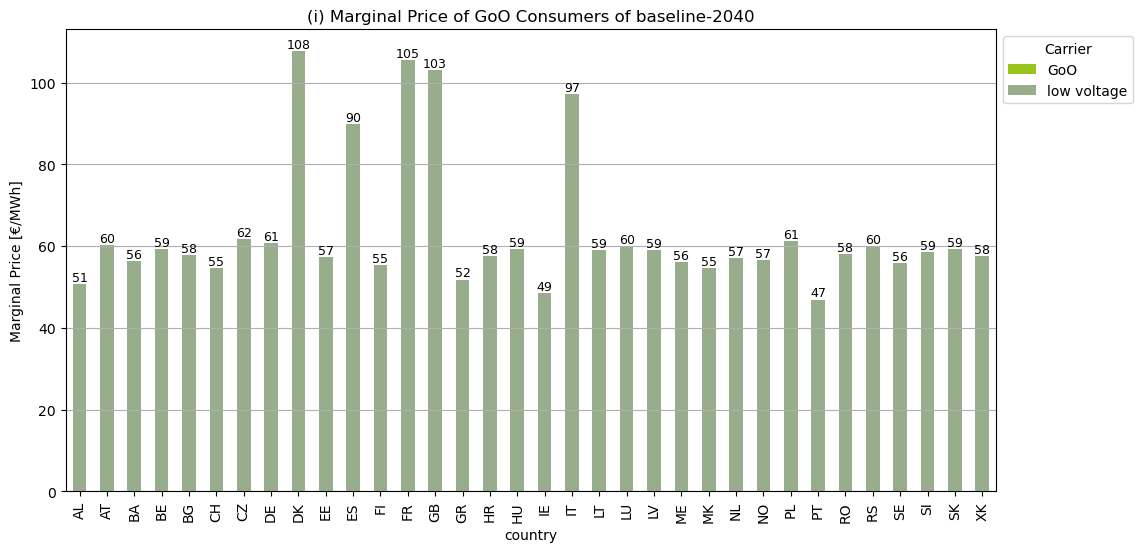

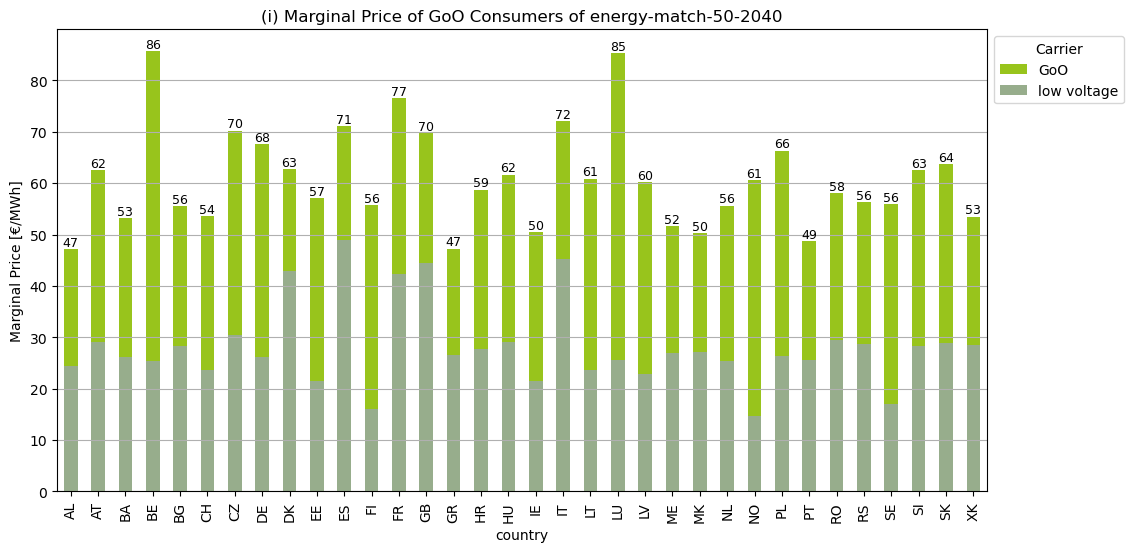

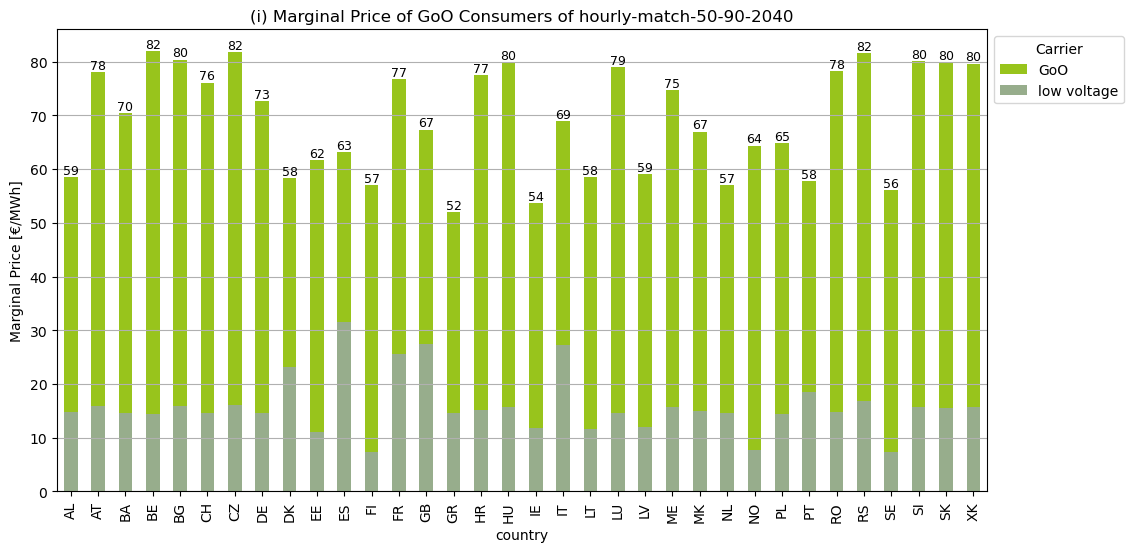

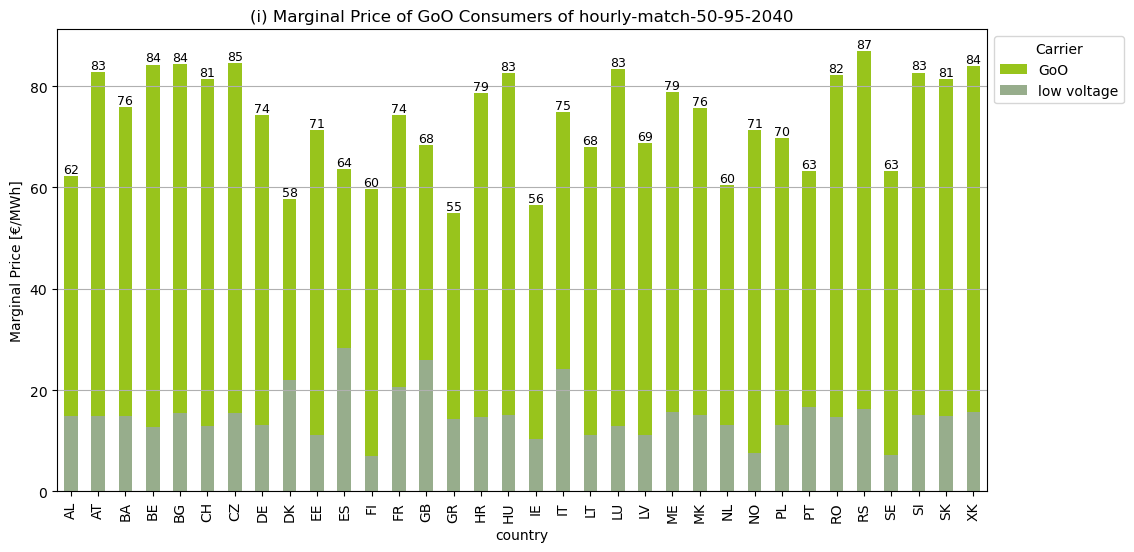

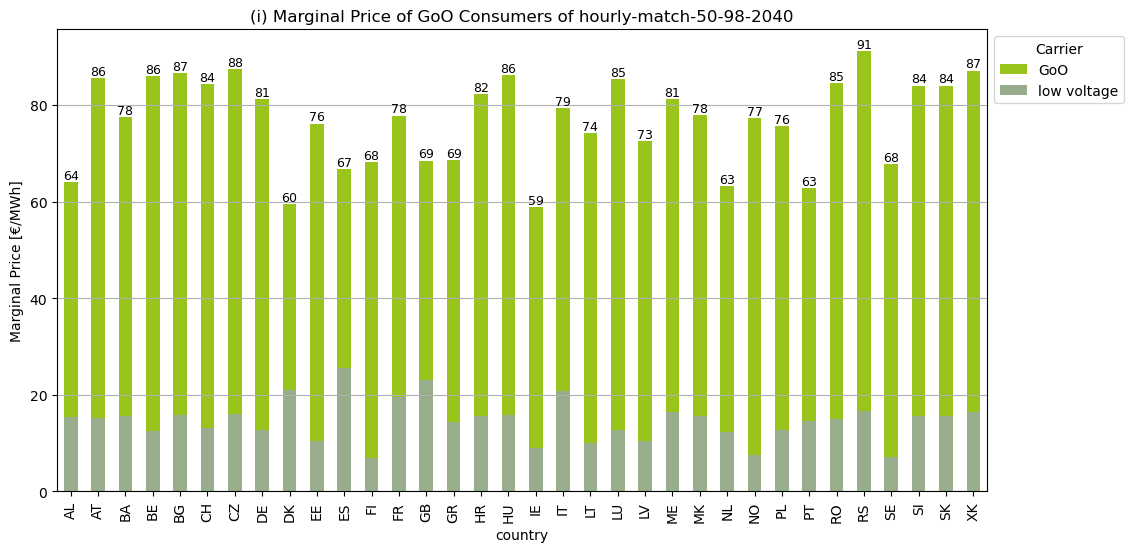

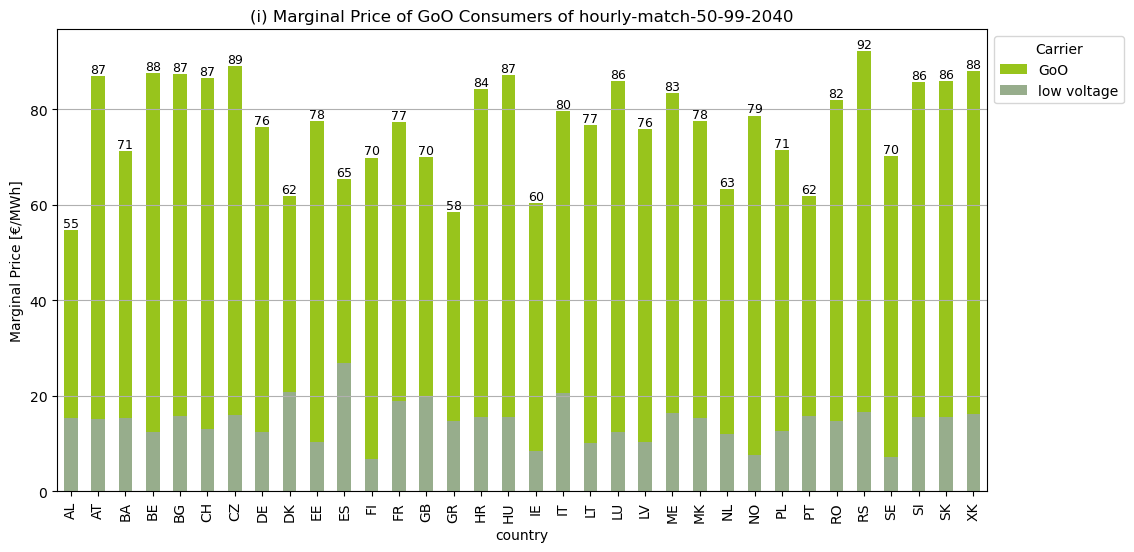

In [95]:
df, _ = get_stats_all(df_networks["network"],"prices")
df = pd.concat([
    df.filter(like="low voltage", axis=0).copy(),
    df.filter(like="GO Demand", axis=0).copy()
])

df["carrier"] = df.index.map(n.buses.carrier)
df["country"] = df.index.map(n.buses.country)

df = df.groupby(["country","carrier"]).sum()

for i in df.columns:
    df_country = df[i]
    df_country = df_country.unstack("country").groupby("carrier").sum()
    
    order = ["low voltage", "GoO"]
    df_country = df_country.reindex(df_country.index.reindex(order)[0])
    
    colors = df_country.index.map(n.carriers.color)
    
    ax = plot_bar(
        df_country, 
        colors, 
        ylabel="Marginal Price [€/MWh]", 
        title=f"(i) Marginal Price of GoO Consumers of {i}",
        vert_lines=False
    )

In [93]:
df

baseline-2025  energy-match-50-2025  \
country carrier                                            
AL      low voltage       49.12860              36.87678   
        GoO                0.00000              13.15722   
AT      low voltage       48.37363              36.38278   
        GoO                0.00000              17.73722   
BA      low voltage       48.69031              36.08219   
...                            ...                   ...   
SI      GoO                0.00000              20.45117   
SK      low voltage       47.61298              35.46629   
        GoO                0.00000              20.41360   
XK      low voltage       48.01188              35.89731   
        GoO                0.00000              15.66630   

                     hourly-match-50-90-2025  hourly-match-50-95-2025  \
country carrier                                                         
AL      low voltage                 27.88350                 27.13371   
        GoO                         57.42996                 63.14938   
AT      low voltage                 27.91669                 27.31480   
        GoO                         53.77423                 57.36564   
BA      low voltage                 26.68731                 25.94669   
...                                      ...                      ...   
SI      GoO                         54.95388                 58.16720   
SK      low voltage                 27.19792                 26.56797   
        GoO                         55.71220                 58.84131   
XK      low voltage                 26.07829                 25.26969   
        GoO                         61.57966                 67.72036   

                     hourly-match-50-98-2025  hourly-match-50-99-2025  \
country carrier                                                         
AL      low voltage                 26.68499                 25.96103   
        GoO                         68.73136                 72.65274   
AT      low voltage                 26.66382                 25.44212   
        GoO                         60.90987                 65.70434   
BA      low voltage                 25.43889                 24.75612   
...                                      ...                      ...   
SI      GoO                         61.56428                 65.40252   
SK      low voltage                 25.83746                 24.61473   
        GoO                         62.13919                 66.86258   
XK      low voltage                 24.74989                 23.97861   
        GoO                         72.29563                 76.60140   

                     baseline-2030  energy-match-50-2030  \
country carrier                                            
AL      low voltage       50.91906              36.01985   
        GoO                0.00000              22.09849   
AT      low voltage       52.16195              33.42437   
        GoO                0.00000              29.67372   
BA      low voltage       52.37578              35.59805   
...                            ...                   ...   
SI      GoO                0.00000              31.30315   
SK      low voltage       51.64604              33.39002   
        GoO                0.00000              31.72180   
XK      low voltage       51.11275              37.26145   
        GoO                0.00000              24.78067   

                     hourly-match-50-90-2030  hourly-match-50-95-2030  ...  \
country carrier                                                        ...   
AL      low voltage                 22.67697                 22.65539  ...   
        GoO                         55.56325                 58.75729  ...   
AT      low voltage                 20.28139                 19.97574  ...   
        GoO                         60.64438                 64.56701  ...   
BA      low voltage                 21.82344                 21.59777  ...   
...          